# Spatial analysis of changes to the Winnipeg Transit Network
## Project by Julia-Simone Rutgers

Using data from the General Transit Feed Service, this notebook aims to analyse changes in access to nearby bus stops and frequent service after the City of Winnipeg introduced the new Primary Transit Network on June 29. The analysis determines where stops were removed, and uses 2021 Census data to evaluate which communities have been most impacted by the service changes.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
from bs4 import BeautifulSoup
import requests

## Part 1: Finding stop differences

Using GTFS stop data for the old and new networks, identify stops that have been lost or added

In [2]:
old_stops = pd.read_csv('old_network/stops.txt')
old_stops.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url
0,10001,10001,Southbound Osborne at Mulvey,49.871261,-97.139518,http://www.winnipegtransit.com/stops/10001
1,10002,10002,Southbound Osborne at Woodward,49.868819,-97.137553,http://www.winnipegtransit.com/stops/10002
2,10003,10003,Southbound Osborne at Brandon,49.867880,-97.136795,http://www.winnipegtransit.com/stops/10003
3,10004,10004,Southbound Osborne at Hethrington,49.866522,-97.135707,http://www.winnipegtransit.com/stops/10004
4,10005,10005,Southbound Osborne at Morley,49.865164,-97.134604,http://www.winnipegtransit.com/stops/10005


In [3]:
new_stops = pd.read_csv('new_network/stops.txt')
new_stops.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url
0,10001,10001,Southbound Osborne at Mulvey,49.871261,-97.139518,https://winnipegtransit.com/stops/10001
1,10002,10002,Southbound Osborne at Glasgow,49.868819,-97.137553,https://winnipegtransit.com/stops/10002
2,10003,10003,Southbound Osborne at Brandon,49.867880,-97.136795,https://winnipegtransit.com/stops/10003
3,10005,10005,Southbound Osborne at Morley,49.865164,-97.134604,https://winnipegtransit.com/stops/10005
4,10006,10006,Southbound Osborne at Maplewood,49.863250,-97.133063,https://winnipegtransit.com/stops/10006


In [4]:
old_stops.dtypes

stop_id        int64
stop_code      int64
stop_name     object
stop_lat     float64
stop_lon     float64
stop_url      object
dtype: object

In [5]:
new_stops.dtypes

stop_id        int64
stop_code      int64
stop_name     object
stop_lat     float64
stop_lon     float64
stop_url      object
dtype: object

I want to combine these into a single frame where the stops that are common across both frames are represented once and the others have an indicator to show whether they came from the left or right frame.

In [6]:
all_stops = pd.merge(
    old_stops,
    new_stops,
    on=['stop_code','stop_lat','stop_lon'],
    how='outer',
    indicator=True,
)
all_stops

,stop_id_x,stop_code,stop_name_x,stop_lat,stop_lon,stop_url_x,stop_id_y,stop_name_y,stop_url_y,_merge
0,10001.0,10001,Southbound Osborne at Mulvey,49.871261,-97.139518,http://www.winnipegtransit.com/stops/10001,10001.0,Southbound Osborne at Mulvey,https://winnipegtransit.com/stops/10001,both
1,10002.0,10002,Southbound Osborne at Woodward,49.868819,-97.137553,http://www.winnipegtransit.com/stops/10002,10002.0,Southbound Osborne at Glasgow,https://winnipegtransit.com/stops/10002,both
2,10003.0,10003,Southbound Osborne at Brandon,49.867880,-97.136795,http://www.winnipegtransit.com/stops/10003,10003.0,Southbound Osborne at Brandon,https://winnipegtransit.com/stops/10003,both
3,10004.0,10004,Southbound Osborne at Hethrington,49.866522,-97.135707,http://www.winnipegtransit.com/stops/10004,NaN,NaN,NaN,left_only
4,10005.0,10005,Southbound Osborne at Morley,49.865164,-97.134604,http://www.winnipegtransit.com/stops/10005,10005.0,Southbound Osborne at Morley,https://winnipegtransit.com/stops/10005,both
...,...,...,...,...,...,...,...,...,...,...
5587,NaN,63010,NaN,49.773879,-97.188767,NaN,63010.0,Eastbound Ken Oblik at Northwater,https://winnipegtransit.com/stops/63010,right_only
5588,NaN,63012,NaN,49.783966,-97.197073,NaN,63012.0,Eastbound Bridge Lake at Del Monica (School Ch...,https://winnipegtransit.com/stops/63012,right_only
5589,NaN,63013,NaN,49.799388,-97.182437,NaN,63013.0,Southbound Frontier at Cadboro,https://winnipegtransit.com/stops/63013,right_only
5590,NaN,63014,NaN,49.776757,-97.194493,NaN,63014.0,Southbound Ken Oblik at Waverley,https://winnipegtransit.com/stops/63014,right_only


### Cleaning data for visualization:

While the rest of this analysis will split the stop data into two data frames in order to analyse lost and added stops separately, this all_stops frame will be used for vizualisations in QGIS.

In [7]:
all_stops_viz = all_stops[['stop_code','stop_lat','stop_lon','_merge','stop_name_x','stop_name_y']].copy()

In [8]:
all_stops_viz.head()

,stop_code,stop_lat,stop_lon,_merge,stop_name_x,stop_name_y
0,10001,49.871261,-97.139518,both,Southbound Osborne at Mulvey,Southbound Osborne at Mulvey
1,10002,49.868819,-97.137553,both,Southbound Osborne at Woodward,Southbound Osborne at Glasgow
2,10003,49.867880,-97.136795,both,Southbound Osborne at Brandon,Southbound Osborne at Brandon
3,10004,49.866522,-97.135707,left_only,Southbound Osborne at Hethrington,NaN
4,10005,49.865164,-97.134604,both,Southbound Osborne at Morley,Southbound Osborne at Morley


In [9]:
# Create new 'stop_name' column --> will be forward filled L-R
# This method feels very risky, but the only columns with blanks are the names. 
# stop name x/y columns will be deleted, leaving one col with a stop name, regardless of which frame the data came from

all_stops_viz['stop_name'] = np.nan
all_stops_viz = all_stops_viz.ffill(axis=1)

In [10]:
all_stops_viz = all_stops_viz[['stop_code','stop_name','stop_lat','stop_lon','_merge']].copy()

In [11]:
# Now that the data is reshaped, will rename merge as 'stop_change'
all_stops_viz.rename(columns={'_merge':'stop_change'},inplace=True)

In [12]:
# Next is to replace values in stop_change column 
# both --> Unchanged 
# left_only --> Removed
# right_only --> New
# Will use a nested np.where

all_stops_viz['stop_change'] = np.where(all_stops_viz['stop_change']=='both','Unchanged',
                                        np.where(all_stops_viz['stop_change']=='left_only','Removed',
                                             np.where(all_stops_viz['stop_change']=='right_only','New', all_stops_viz['stop_change'])))

In [13]:
# Export
all_stops_viz.to_csv('data_output/allstops.csv')

In [14]:
# left = old
# find left_only, or lost stops

lost_stops = all_stops[all_stops['_merge']=='left_only']
lost_stops

,stop_id_x,stop_code,stop_name_x,stop_lat,stop_lon,stop_url_x,stop_id_y,stop_name_y,stop_url_y,_merge
3,10004.0,10004,Southbound Osborne at Hethrington,49.866522,-97.135707,http://www.winnipegtransit.com/stops/10004,NaN,NaN,NaN,left_only
10,10011.0,10011,Northbound Eccles at Balfour,49.864089,-97.118754,http://www.winnipegtransit.com/stops/10011,NaN,NaN,NaN,left_only
11,10012.0,10012,Southbound Eccles at Balfour,49.864110,-97.118962,http://www.winnipegtransit.com/stops/10012,NaN,NaN,NaN,left_only
18,10023.0,10023,Northbound Eccles at Morley,49.868965,-97.122684,http://www.winnipegtransit.com/stops/10023,NaN,NaN,NaN,left_only
19,10024.0,10024,Eastbound Morley at Eccles,49.868846,-97.123092,http://www.winnipegtransit.com/stops/10024,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...
5496,62023.0,62023,Westbound Bison at Appleford,49.791002,-97.209359,http://www.winnipegtransit.com/stops/62023,NaN,NaN,NaN,left_only
5497,62024.0,62024,Eastbound Bison at Appleford,49.790671,-97.208912,http://www.winnipegtransit.com/stops/62024,NaN,NaN,NaN,left_only
5500,62027.0,62027,Eastbound Scurfield at Waverley East,49.818100,-97.177940,http://www.winnipegtransit.com/stops/62027,NaN,NaN,NaN,left_only
5505,62032.0,62032,Westbound Scurfield at Waverley East,49.818216,-97.177311,http://www.winnipegtransit.com/stops/62032,NaN,NaN,NaN,left_only


In [15]:
# right = new
# find right_only, or added stops
added_stops = all_stops[all_stops['_merge']=='right_only']
added_stops

,stop_id_x,stop_code,stop_name_x,stop_lat,stop_lon,stop_url_x,stop_id_y,stop_name_y,stop_url_y,_merge
139,NaN,10153,NaN,49.879791,-97.137994,NaN,10153.0,Southbound Donald at Stradbrook,https://winnipegtransit.com/stops/10153,right_only
146,NaN,10166,NaN,49.881948,-97.137354,NaN,10166.0,Southbound Donald at River,https://winnipegtransit.com/stops/10166,right_only
180,NaN,10226,NaN,49.879649,-97.169722,NaN,10226.0,Northbound Arlington at Wolseley,https://winnipegtransit.com/stops/10226,right_only
592,NaN,10673,NaN,49.887809,-97.140456,NaN,10673.0,Southbound Donald at Broadway,https://winnipegtransit.com/stops/10673,right_only
684,NaN,10798,NaN,49.870337,-97.163339,NaN,10798.0,Southbound Stafford at Grosvenor,https://winnipegtransit.com/stops/10798,right_only
...,...,...,...,...,...,...,...,...,...,...
5587,NaN,63010,NaN,49.773879,-97.188767,NaN,63010.0,Eastbound Ken Oblik at Northwater,https://winnipegtransit.com/stops/63010,right_only
5588,NaN,63012,NaN,49.783966,-97.197073,NaN,63012.0,Eastbound Bridge Lake at Del Monica (School Ch...,https://winnipegtransit.com/stops/63012,right_only
5589,NaN,63013,NaN,49.799388,-97.182437,NaN,63013.0,Southbound Frontier at Cadboro,https://winnipegtransit.com/stops/63013,right_only
5590,NaN,63014,NaN,49.776757,-97.194493,NaN,63014.0,Southbound Ken Oblik at Waverley,https://winnipegtransit.com/stops/63014,right_only


In [16]:
# check the boths

overlap = all_stops[all_stops['_merge']=='both']
overlap

,stop_id_x,stop_code,stop_name_x,stop_lat,stop_lon,stop_url_x,stop_id_y,stop_name_y,stop_url_y,_merge
0,10001.0,10001,Southbound Osborne at Mulvey,49.871261,-97.139518,http://www.winnipegtransit.com/stops/10001,10001.0,Southbound Osborne at Mulvey,https://winnipegtransit.com/stops/10001,both
1,10002.0,10002,Southbound Osborne at Woodward,49.868819,-97.137553,http://www.winnipegtransit.com/stops/10002,10002.0,Southbound Osborne at Glasgow,https://winnipegtransit.com/stops/10002,both
2,10003.0,10003,Southbound Osborne at Brandon,49.867880,-97.136795,http://www.winnipegtransit.com/stops/10003,10003.0,Southbound Osborne at Brandon,https://winnipegtransit.com/stops/10003,both
4,10005.0,10005,Southbound Osborne at Morley,49.865164,-97.134604,http://www.winnipegtransit.com/stops/10005,10005.0,Southbound Osborne at Morley,https://winnipegtransit.com/stops/10005,both
5,10006.0,10006,Southbound Osborne at Kylemore,49.863250,-97.133063,http://www.winnipegtransit.com/stops/10006,10006.0,Southbound Osborne at Maplewood,https://winnipegtransit.com/stops/10006,both
...,...,...,...,...,...,...,...,...,...,...
5516,62043.0,62043,Southbound Waverley at Wilkes,49.846307,-97.179606,http://www.winnipegtransit.com/stops/62043,62043.0,Southbound Waverley at Wilkes,https://winnipegtransit.com/stops/62043,both
5519,62045.0,62045,Southbound Brady at Vitran,49.812154,-97.219532,http://www.winnipegtransit.com/stops/62045,62045.0,Southbound Brady at Vitran,https://winnipegtransit.com/stops/62045,both
5520,62046.0,62046,Eastbound Fleetwood at Royal Oak,49.810910,-97.215908,http://www.winnipegtransit.com/stops/62046,62046.0,Eastbound Fleetwood at Royal Oak,https://winnipegtransit.com/stops/62046,both
5521,62047.0,62047,Westbound Fleetwood at Royal Oak,49.811065,-97.216013,http://www.winnipegtransit.com/stops/62047,62047.0,Westbound Fleetwood at Royal Oak,https://winnipegtransit.com/stops/62047,both


In [17]:
# Check the math:

len(old_stops) - len(lost_stops) + len(added_stops)

# Should be 3872

3872

### Clean for analysis:

In [18]:
lost_stops_clean = lost_stops[['stop_code', 'stop_name_x', 'stop_lat','stop_lon']].copy()
lost_stops_clean.rename(columns={'stop_name_x':'stop_name'}, inplace=True)
lost_stops_clean.head()

,stop_code,stop_name,stop_lat,stop_lon
3,10004,Southbound Osborne at Hethrington,49.866522,-97.135707
10,10011,Northbound Eccles at Balfour,49.864089,-97.118754
11,10012,Southbound Eccles at Balfour,49.864110,-97.118962
18,10023,Northbound Eccles at Morley,49.868965,-97.122684
19,10024,Eastbound Morley at Eccles,49.868846,-97.123092


In [19]:
added_stops_clean = added_stops[['stop_code', 'stop_name_y', 'stop_lat','stop_lon']].copy()
added_stops_clean.rename(columns={'stop_name_y':'stop_name'}, inplace=True)
added_stops_clean.head()

,stop_code,stop_name,stop_lat,stop_lon
139,10153,Southbound Donald at Stradbrook,49.879791,-97.137994
146,10166,Southbound Donald at River,49.881948,-97.137354
180,10226,Northbound Arlington at Wolseley,49.879649,-97.169722
592,10673,Southbound Donald at Broadway,49.887809,-97.140456
684,10798,Southbound Stafford at Grosvenor,49.870337,-97.163339


### Add geometry for mapping:

In [20]:
lost_stops_map = gpd.GeoDataFrame(
    lost_stops_clean, 
    geometry=gpd.points_from_xy(lost_stops_clean.stop_lon, lost_stops_clean.stop_lat), crs="EPSG:4326"
)
lost_stops_map.head()

,stop_code,stop_name,stop_lat,stop_lon,geometry
3,10004,Southbound Osborne at Hethrington,49.866522,-97.135707,POINT (-97.13571 49.86652)
10,10011,Northbound Eccles at Balfour,49.864089,-97.118754,POINT (-97.11875 49.86409)
11,10012,Southbound Eccles at Balfour,49.864110,-97.118962,POINT (-97.11896 49.86411)
18,10023,Northbound Eccles at Morley,49.868965,-97.122684,POINT (-97.12268 49.86897)
19,10024,Eastbound Morley at Eccles,49.868846,-97.123092,POINT (-97.12309 49.86885)


In [21]:
added_stops_map = gpd.GeoDataFrame(
   added_stops_clean, 
    geometry=gpd.points_from_xy(added_stops_clean.stop_lon, added_stops_clean.stop_lat), crs="EPSG:4326"
)
added_stops_map.head()

,stop_code,stop_name,stop_lat,stop_lon,geometry
139,10153,Southbound Donald at Stradbrook,49.879791,-97.137994,POINT (-97.13799 49.87979)
146,10166,Southbound Donald at River,49.881948,-97.137354,POINT (-97.13735 49.88195)
180,10226,Northbound Arlington at Wolseley,49.879649,-97.169722,POINT (-97.16972 49.87965)
592,10673,Southbound Donald at Broadway,49.887809,-97.140456,POINT (-97.14046 49.88781)
684,10798,Southbound Stafford at Grosvenor,49.870337,-97.163339,POINT (-97.16334 49.87034)


---

## Part 2: City-wide stop change analysis

Using the stop losses/gains, calculate the average number of stops lost and added per km2 of Winnipeg

In [22]:
# First, a little simple maths...

print(f'The old Winnipeg Transit network had a total of {len(old_stops)} stops.') 
print(f'The new network has {len(new_stops)}.')
print(f'In total: {len(lost_stops_clean)} of the original stops were removed and {len(added_stops_clean)} were created, resulting in a difference of {len(old_stops)-len(new_stops)} stops.')

The old Winnipeg Transit network had a total of 5137 stops.
The new network has 3872.
In total: 1720 of the original stops were removed and 455 were created, resulting in a difference of 1265 stops.


In [23]:
# read in winnipeg city boundary map
winnipeg = gpd.read_file('map_layers/winnipeg-limit.geojson')

**The right projection:** The standard projection for Manitoba (most of it at least) is NAD 83 UTM Zone 14N

There are two versions of this in EPSG:

- 26914 (The 'standard')
- 3158 (CSRS)

I'll work with 3158 as it has better accuracy within Canada


In [24]:
winnipeg = winnipeg.to_crs("epsg:3158")

In [25]:
# Align CRS (just in case)

lost_stops_map = lost_stops_map.to_crs(winnipeg.crs)
added_stops_map = added_stops_map.to_crs(winnipeg.crs)

<Axes: >

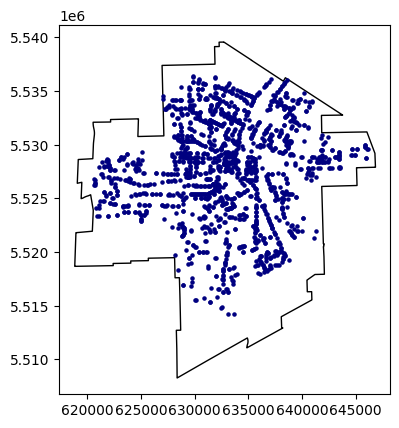

In [26]:
# Plot lost stops on Winnipeg outline

base = winnipeg.plot(color='white', edgecolor='black')

lost_stops_map.plot(ax=base, marker='o', color='navy', markersize=5)

In [519]:
# Just a quick check regarding the projection: what is the area of Winnipeg (should be ~ 475 km2)?

winnipeg.area

0    4.752072e+08
dtype: float64

### Stops lost/added per square km:

In [28]:
# Convert area to square km
wpg_area = int(winnipeg.area)/1000000

/var/folders/1d/j2lx647d3235w452yff34nqh0000gp/T/ipykernel_12746/1598103727.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  wpg_area = int(winnipeg.area)/1000000


In [29]:
wpg_area

475.207173

In [30]:
loss = len(lost_stops_clean)/wpg_area
gain = len(added_stops_clean)/wpg_area
change = (len(lost_stops_clean)-len(added_stops_clean))/wpg_area

print(f'Winnipeg removed {loss:.2f} bus stops per square kilometre.')
print(f'The city added {gain:.2f} bus stops per square kilometre.')
print(f'Overall, Winnipeg lost {change:.2f} bus stops per sq km.')

Winnipeg removed 3.62 bus stops per square kilometre.
The city added 0.96 bus stops per square kilometre.
Overall, Winnipeg lost 2.66 bus stops per sq km.


---

## Part 3: Stop gains / losses by areas of higher poverty

The 2021 Census includes a poverty rate measure, which refers to the percentage of residents below the market basket measure poverty line — in other words residents who cannot afford a predetermined basket of basic goods. 

This step will analyse the number of stops removed from areas with higher vs lower poverty rates.

In [283]:
# Read in base map

census = gpd.read_file('census-analysis/winnipeg-census-tracts.geojson')

In [284]:
census = census.to_crs("epsg:3158")

In [285]:
census.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   CTUID     170 non-null    object  
 1   DGUID     170 non-null    object  
 2   CTNAME    170 non-null    object  
 3   LANDAREA  170 non-null    float64 
 4   PRUID     170 non-null    object  
 5   geometry  170 non-null    geometry
dtypes: float64(1), geometry(1), object(4)
memory usage: 8.1+ KB


In [286]:
# Add in data — first poverty

povertyrate = pd.read_csv('census-files/Census tract - Poverty rate in 2020 (MBM) (%).csv')

In [287]:
povertyrate.head()

,DGUID,Location,Poverty rate in 2020 (MBM) (%)
0,2021S05076020501.01,6020501.01 [CT] (Man.),34.0
1,2021S05076020022.00,6020022.00 [CT] (Man.),32.9
2,2021S05076020015.00,6020015.00 [CT] (Man.),30.8
3,2021S05076020023.00,6020023.00 [CT] (Man.),28.2
4,2021S05076020025.00,6020025.00 [CT] (Man.),27.5


In [288]:
# Merge census and poverty rate using the unique DGUID code
census = census.merge(povertyrate, on='DGUID')

In [289]:
# Quick change of column name
census = census.rename(columns={'Poverty rate in 2020 (MBM) (%)':'poverty_rate'})

In [290]:
# And dealing with a sneaky 'x' (should be NA)
census['poverty_rate'] = census['poverty_rate'].replace('x','')

In [291]:
census['poverty_rate'] = pd.to_numeric(census['poverty_rate'], errors='ignore')


/var/folders/1d/j2lx647d3235w452yff34nqh0000gp/T/ipykernel_12746/863639434.py:1: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  census['poverty_rate'] = pd.to_numeric(census['poverty_rate'], errors='ignore')


### Lost stops:

<Axes: >

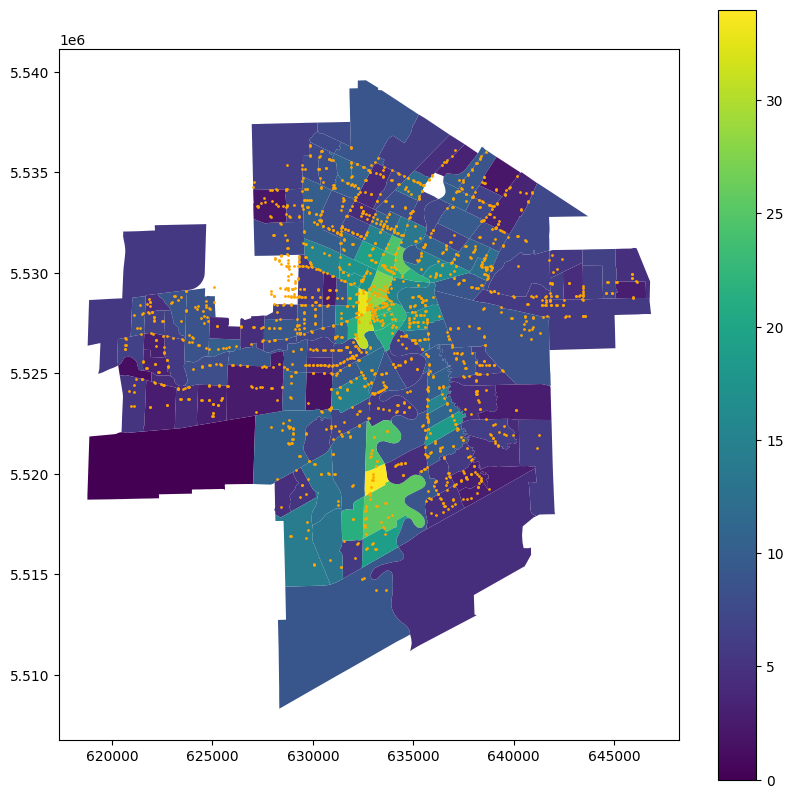

In [520]:
# Plot by poverty rate

base = census.plot(
    column='poverty_rate', 
    legend=True,
    figsize=(10,10),
)
# Plot lost stops in yellow
lost_stops_map.plot(ax=base, marker='o', color='orange', markersize=1)

Starry night of the lost bus stops, oh my!

In [293]:
census.head()

,CTUID,DGUID,CTNAME,LANDAREA,PRUID,geometry,Location,poverty_rate
0,6020520.05,2021S05076020520.05,0520.05,26.3221,46,"MULTIPOLYGON (((627137.713 5522903.083, 627084...",6020520.05 [CT] (Man.),0.0
1,6020001.00,2021S05076020001.00,0001.00,1.7766,46,"MULTIPOLYGON (((634143.755 5525860.523, 634369...",6020001.00 [CT] (Man.),6.2
2,6020002.00,2021S05076020002.00,0002.00,1.8471,46,"MULTIPOLYGON (((634609.707 5524380.088, 634661...",6020002.00 [CT] (Man.),8.5
3,6020003.00,2021S05076020003.00,0003.00,1.4086,46,"MULTIPOLYGON (((632814.973 5524062.486, 632809...",6020003.00 [CT] (Man.),11.8
4,6020005.00,2021S05076020005.00,0005.00,2.3718,46,"MULTIPOLYGON (((630927.709 5523691.088, 630911...",6020005.00 [CT] (Man.),1.7


In [294]:
# Calculate the number of bus stops in each polygon

loss_in_region = lost_stops_map.sjoin(census,how='right',predicate='within')
loss_in_region

,index_left,stop_code,stop_name,stop_lat,stop_lon,CTUID,DGUID,CTNAME,LANDAREA,PRUID,geometry,Location,poverty_rate
0,NaN,NaN,NaN,NaN,NaN,6020520.05,2021S05076020520.05,0520.05,26.3221,46,"MULTIPOLYGON (((627137.713 5522903.083, 627084...",6020520.05 [CT] (Man.),0.0
1,10.0,10011.0,Northbound Eccles at Balfour,49.864089,-97.118754,6020001.00,2021S05076020001.00,0001.00,1.7766,46,"MULTIPOLYGON (((634143.755 5525860.523, 634369...",6020001.00 [CT] (Man.),6.2
1,11.0,10012.0,Southbound Eccles at Balfour,49.864110,-97.118962,6020001.00,2021S05076020001.00,0001.00,1.7766,46,"MULTIPOLYGON (((634143.755 5525860.523, 634369...",6020001.00 [CT] (Man.),6.2
1,18.0,10023.0,Northbound Eccles at Morley,49.868965,-97.122684,6020001.00,2021S05076020001.00,0001.00,1.7766,46,"MULTIPOLYGON (((634143.755 5525860.523, 634369...",6020001.00 [CT] (Man.),6.2
1,19.0,10024.0,Eastbound Morley at Eccles,49.868846,-97.123092,6020001.00,2021S05076020001.00,0001.00,1.7766,46,"MULTIPOLYGON (((634143.755 5525860.523, 634369...",6020001.00 [CT] (Man.),6.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,5408.0,61230.0,Northbound Centre at Jacob's Creek,49.793083,-97.197388,6020500.13,2021S05076020500.13,0500.13,6.7040,46,"MULTIPOLYGON (((629953.657 5518010, 629945.595...",6020500.13 [CT] (Man.),14.1
169,5469.0,61295.0,Westbound Waverley at Eaglewood,49.777852,-97.193758,6020500.13,2021S05076020500.13,0500.13,6.7040,46,"MULTIPOLYGON (((629953.657 5518010, 629945.595...",6020500.13 [CT] (Man.),14.1
169,5470.0,61296.0,Eastbound Waverley at Eaglewood East,49.777763,-97.193289,6020500.13,2021S05076020500.13,0500.13,6.7040,46,"MULTIPOLYGON (((629953.657 5518010, 629945.595...",6020500.13 [CT] (Man.),14.1
169,5496.0,62023.0,Westbound Bison at Appleford,49.791002,-97.209359,6020500.13,2021S05076020500.13,0500.13,6.7040,46,"MULTIPOLYGON (((629953.657 5518010, 629945.595...",6020500.13 [CT] (Man.),14.1


In [295]:
loss_in_region.groupby('DGUID')['stop_code'].count()

DGUID
2021S05076020001.00    11
2021S05076020002.00    17
2021S05076020003.00    10
2021S05076020004.01     8
2021S05076020004.02    13
                       ..
2021S05076020560.11     3
2021S05076020560.12     5
2021S05076020560.13     2
2021S05076020560.14     9
2021S05076020560.15     8
Name: stop_code, Length: 170, dtype: int64

In [296]:
# Assign this to census

loss_in_region = loss_in_region.groupby('DGUID')['stop_code'].count().to_frame()
census = census.merge(loss_in_region, on='DGUID')

In [297]:
census = census.rename(columns={'stop_code':'lost_stops'})

In [298]:
census.head()

,CTUID,DGUID,CTNAME,LANDAREA,PRUID,geometry,Location,poverty_rate,lost_stops
0,6020520.05,2021S05076020520.05,0520.05,26.3221,46,"MULTIPOLYGON (((627137.713 5522903.083, 627084...",6020520.05 [CT] (Man.),0.0,0
1,6020001.00,2021S05076020001.00,0001.00,1.7766,46,"MULTIPOLYGON (((634143.755 5525860.523, 634369...",6020001.00 [CT] (Man.),6.2,11
2,6020002.00,2021S05076020002.00,0002.00,1.8471,46,"MULTIPOLYGON (((634609.707 5524380.088, 634661...",6020002.00 [CT] (Man.),8.5,17
3,6020003.00,2021S05076020003.00,0003.00,1.4086,46,"MULTIPOLYGON (((632814.973 5524062.486, 632809...",6020003.00 [CT] (Man.),11.8,10
4,6020005.00,2021S05076020005.00,0005.00,2.3718,46,"MULTIPOLYGON (((630927.709 5523691.088, 630911...",6020005.00 [CT] (Man.),1.7,9


### Added stops:

<Axes: >

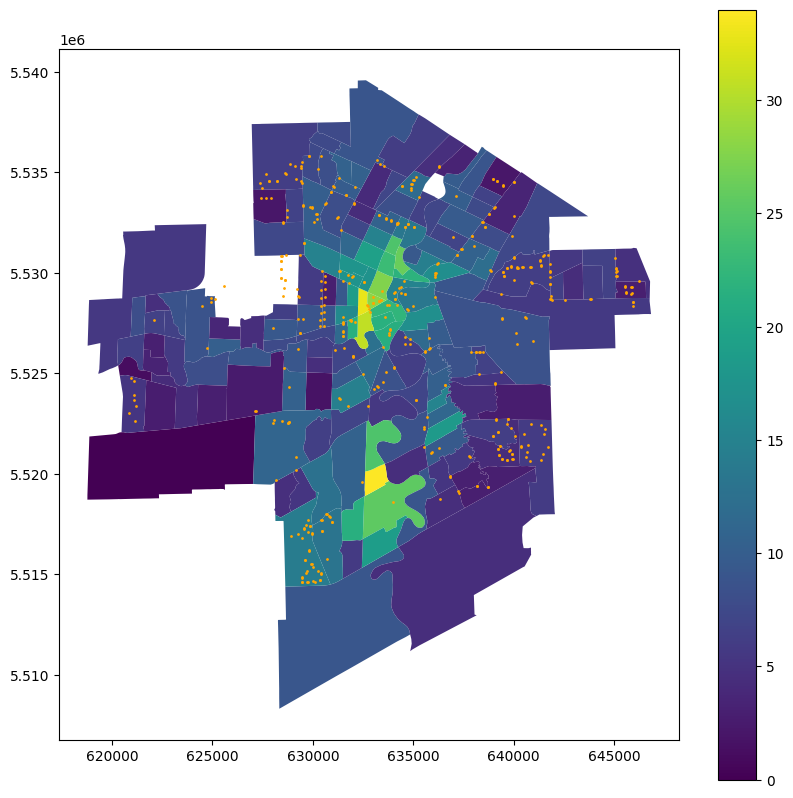

In [299]:
# Now the same for added stops!

# Plot by mbm

base = census.plot(
    column='poverty_rate', 
    legend=True,
    figsize=(10,10),
)
# Plot lost stops in orange
added_stops_map.plot(ax=base, marker='o', color='orange', markersize=1)

In [300]:
# Calculate gained stops per polygon
gain_in_region = added_stops_map.sjoin(census,how='right',predicate='within')
gain_in_region.groupby('DGUID')['stop_code'].count()

DGUID
2021S05076020001.00    0
2021S05076020002.00    7
2021S05076020003.00    2
2021S05076020004.01    0
2021S05076020004.02    3
                      ..
2021S05076020560.11    1
2021S05076020560.12    2
2021S05076020560.13    0
2021S05076020560.14    0
2021S05076020560.15    0
Name: stop_code, Length: 170, dtype: int64

In [301]:
# Assign to pov_bounds
gain_in_region = gain_in_region.groupby('DGUID')['stop_code'].count().to_frame()
census = census.merge(gain_in_region, on='DGUID')

In [302]:
census=census.rename(columns={'stop_code': 'added_stops'})

In [303]:
# One more column - stop change

census['stop_change'] = census['added_stops']- census['lost_stops'] 
census['change_per_km'] = census['stop_change']/census['LANDAREA']

In [304]:
census.sample(10)

,CTUID,DGUID,CTNAME,LANDAREA,PRUID,geometry,Location,poverty_rate,lost_stops,added_stops,stop_change,change_per_km
126,6020142.03,2021S05076020142.03,0142.03,0.7828,46,"MULTIPOLYGON (((637778.409 5534978.217, 637751...",6020142.03 [CT] (Man.),9.8,7,0,-7,-8.942259
41,6020042.00,2021S05076020042.00,0042.00,0.4795,46,"MULTIPOLYGON (((634127.708 5531793.081, 634313...",6020042.00 [CT] (Man.),24.5,3,0,-3,-6.256517
79,6020553.00,2021S05076020553.00,0553.00,1.3196,46,"MULTIPOLYGON (((635247.708 5533632.079, 635232...",6020553.00 [CT] (Man.),11.7,19,10,-9,-6.820249
133,6020540.04,2021S05076020540.04,0540.04,0.7602,46,"MULTIPOLYGON (((622917.425 5528139.046, 622948...",6020540.04 [CT] (Man.),6.6,2,0,-2,-2.630887
115,6020130.01,2021S05076020130.01,0130.01,1.6196,46,"MULTIPOLYGON (((638599.709 5530854.085, 638566...",6020130.01 [CT] (Man.),10.6,14,5,-9,-5.556928
151,6020560.09,2021S05076020560.09,0560.09,1.3647,46,"MULTIPOLYGON (((631857.709 5537517.08, 631872....",6020560.09 [CT] (Man.),7.6,0,0,0,0.000000
140,6020501.03,2021S05076020501.03,0501.03,2.2267,46,"MULTIPOLYGON (((632920.711 5522369.084, 632932...",6020501.03 [CT] (Man.),24.5,10,0,-10,-4.490951
2,6020002.00,2021S05076020002.00,0002.00,1.8471,46,"MULTIPOLYGON (((634609.707 5524380.088, 634661...",6020002.00 [CT] (Man.),8.5,17,7,-10,-5.413892
107,6020100.01,2021S05076020100.01,0100.01,2.3405,46,"MULTIPOLYGON (((637306.708 5518967.092, 637348...",6020100.01 [CT] (Man.),4.5,18,2,-16,-6.836146
51,6020104.00,2021S05076020104.00,0104.00,1.2842,46,"MULTIPOLYGON (((636839.673 5525347.096, 636812...",6020104.00 [CT] (Man.),10.3,8,2,-6,-4.672169


### Area-based calculations:


In [305]:
census.head()

,CTUID,DGUID,CTNAME,LANDAREA,PRUID,geometry,Location,poverty_rate,lost_stops,added_stops,stop_change,change_per_km
0,6020520.05,2021S05076020520.05,0520.05,26.3221,46,"MULTIPOLYGON (((627137.713 5522903.083, 627084...",6020520.05 [CT] (Man.),0.0,0,0,0,0.000000
1,6020001.00,2021S05076020001.00,0001.00,1.7766,46,"MULTIPOLYGON (((634143.755 5525860.523, 634369...",6020001.00 [CT] (Man.),6.2,11,0,-11,-6.191602
2,6020002.00,2021S05076020002.00,0002.00,1.8471,46,"MULTIPOLYGON (((634609.707 5524380.088, 634661...",6020002.00 [CT] (Man.),8.5,17,7,-10,-5.413892
3,6020003.00,2021S05076020003.00,0003.00,1.4086,46,"MULTIPOLYGON (((632814.973 5524062.486, 632809...",6020003.00 [CT] (Man.),11.8,10,2,-8,-5.679398
4,6020005.00,2021S05076020005.00,0005.00,2.3718,46,"MULTIPOLYGON (((630927.709 5523691.088, 630911...",6020005.00 [CT] (Man.),1.7,9,0,-9,-3.794586


In [306]:
census['poverty_rate'].describe()

count    168.000000
mean       9.854167
std        6.511784
min        0.000000
25%        5.775000
50%        8.150000
75%       11.625000
max       34.000000
Name: poverty_rate, dtype: float64

<Axes: ylabel='Frequency'>

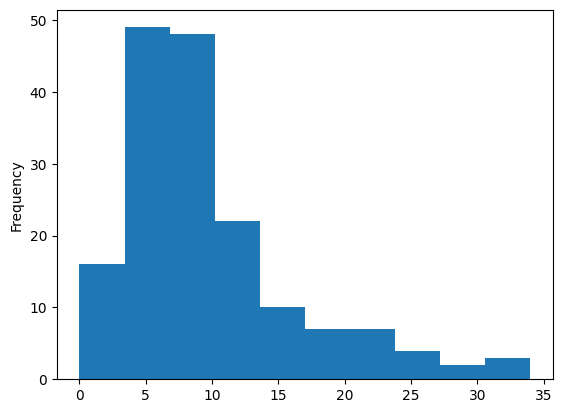

In [307]:
census['poverty_rate'].plot(kind='hist')

In [362]:
census.poverty_rate.quantile()

np.float64(8.149999999999999)

This poverty rate is calculated using the market basket measure. Essientially, it is the percentage of the population living below the poverty line in each area — in other words unable to afford a pre-defined 'basket' of basic goods.

This is defined in further detail [here](https://www150.statcan.gc.ca/n1/pub/75f0002m/75f0002m2022008-eng.htm). It's not a perfect measure. I've read some fascinating critiques. It's also 5-year-old data. But it's the most recent available and I'm going to make it work. Next year's census can't come soon enough!

I'm going to break up the data into quantiles Statistics Canada and the city have used to determine "high needs" areas. The median is 8.15, so the first quantile is "below" average (mostly), with higher needs areas 20% or more.

mbm 0-9

mbm 10-19

mbm 20-29

mbm 30 + 



In [309]:
quart_analysis = []
quants = census[census['poverty_rate'].between(0,10, inclusive='left')], census[census['poverty_rate'].between(10,20, inclusive='left')] ,census[census['poverty_rate'].between(20,30, inclusive='left')], census[census['poverty_rate']>29]
i=1
for quant in quants:
    row = {}
    row['quant'] = i
    row['area'] = quant.LANDAREA.sum()
    row['loss_total']=quant.lost_stops.sum()
    row['gain_total']=quant.added_stops.sum()
    row['stop_change'] = quant.stop_change.sum()
    row['change_per_km'] = quant.stop_change.sum()/quant.LANDAREA.sum()
    quant_analysis.append(row)
    i+=1

In [310]:
quant_analysis = pd.DataFrame(quant_analysis)
quant_analysis

,quant,area,loss_total,gain_total,stop_change,change_per_km
0,1,354.5083,1064,267,-797,-2.248184
1,2,74.7041,453,150,-303,-4.056002
2,3,16.0219,129,22,-107,-6.678359
3,4,2.6582,23,2,-21,-7.900083


In [311]:
quant_analysis.quant = ['mbm 0-9', 'mbm 10-19', 'mbm 20-29', 'mbm 30+']
quant_analysis

,quant,area,loss_total,gain_total,stop_change,change_per_km
0,mbm 0-9,354.5083,1064,267,-797,-2.248184
1,mbm 10-19,74.7041,453,150,-303,-4.056002
2,mbm 20-29,16.0219,129,22,-107,-6.678359
3,mbm 30+,2.6582,23,2,-21,-7.900083


In [312]:
quant_analysis.to_csv('census-analysis/poverty-quartile-analysis.csv')

## RESULTS:

<span style="font-size:1.5em;">
    
Between the old network and new network, there are **2.7 fewer bus stops per square kilometre** across the entire city. The city removed 3.6 stops per sq. km. and added 1 stop per sq. km. on average. 

As the rate of people living below the poverty line incraeses, so too does the number of stops removed.

In high-needs areas of the city, where the market basket measure is between 20-29%, there are now **6.7 fewer bus stops per square kilometre** 

Areas with an mbm greater than 30% have lost nearly **8 stops per square kilometre**, a more than twice city wide average.

</span>

---


## Add data about percentage of population using public transit to commute

Also included in the census data is a measure of the proportion of residents who primarily commute on public transit. Using the same process as above, this section will analyse the relationship between transit use and stop loss.

In [313]:
# Add transit commuter data:
transit_users = pd.read_csv('census-files/Census tract - Percentage of commuters_ public transit.csv')

In [314]:
census = census.merge(transit_users, on=['DGUID', 'Location'])

In [316]:
census.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 13 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   CTUID                                    170 non-null    object  
 1   DGUID                                    170 non-null    object  
 2   CTNAME                                   170 non-null    object  
 3   LANDAREA                                 170 non-null    float64 
 4   PRUID                                    170 non-null    object  
 5   geometry                                 170 non-null    geometry
 6   Location                                 170 non-null    object  
 7   poverty_rate                             168 non-null    float64 
 8   lost_stops                               170 non-null    int64   
 9   added_stops                              170 non-null    int64   
 10  stop_change                   

In [521]:
# Data cleaning and histogram to get a sense of results

In [317]:
census = census.rename(columns={'Percentage of commuters: public transit': 'transit_users'})

In [319]:
census['transit_users'] = census['transit_users'].replace('x','')

In [320]:
census['transit_users'] = census['transit_users'] = pd.to_numeric(census['transit_users'], errors='ignore')


/var/folders/1d/j2lx647d3235w452yff34nqh0000gp/T/ipykernel_12746/4144839727.py:1: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  census['transit_users'] = census['transit_users'] = pd.to_numeric(census['transit_users'], errors='ignore')


In [321]:
census['transit_users'].describe()

count    169.000000
mean       9.447337
std        6.620549
min        0.000000
25%        5.000000
50%        8.300000
75%       11.800000
max       36.900000
Name: transit_users, dtype: float64

<Axes: ylabel='Frequency'>

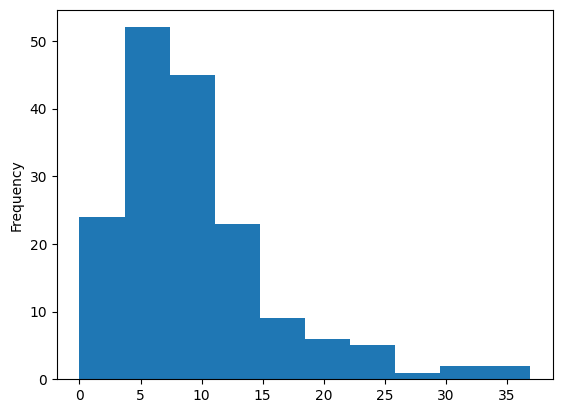

In [322]:
census['transit_users'].plot(kind='hist')

In [326]:
# Suprisingly similar distribution to the poverty rate. Will use the same baskets
# Calculate relationship to stop difference:

transit_user_analysis = []

quants = census[census['transit_users'].between(0,10, inclusive='left')], census[census['transit_users'].between(10,20, inclusive='left')] ,census[census['transit_users'].between(20,30, inclusive='left')], census[census['transit_users']>29]
i=1
for quant in quants:
    row = {}
    row['transit_commuters'] = i
    row['area'] = quant.LANDAREA.sum()
    row['loss_total']=quant.lost_stops.sum()
    row['gain_total']=quant.added_stops.sum()
    row['stop_change'] = quant.stop_change.sum()
    row['change_per_km'] = quant.stop_change.sum()/quant.LANDAREA.sum()
    transit_user_analysis.append(row)
    i+=1

In [327]:
transit_user_analysis = pd.DataFrame(transit_user_analysis)
transit_user_analysis

,transit_commuters,area,loss_total,gain_total,stop_change,change_per_km
0,1,385.8060,1154,343,-811,-2.102093
1,2,59.4479,422,85,-337,-5.668829
2,3,12.5903,87,15,-72,-5.718688
3,4,4.0731,61,13,-48,-11.784636


In [329]:
transit_user_analysis.transit_commuters = [ '0-9%', '10-19%', '20-29%', '30+%']
transit_user_analysis

,transit_commuters,area,loss_total,gain_total,stop_change,change_per_km
0,0-9%,385.8060,1154,343,-811,-2.102093
1,10-19%,59.4479,422,85,-337,-5.668829
2,20-29%,12.5903,87,15,-72,-5.718688
3,30+%,4.0731,61,13,-48,-11.784636


<span style="font-size:1.5em;">

The pattern continues! A MUCH higher rate of stop removal in high-use areas (predominantly downtown) and much smaller in the areas with fewer transit commuters. 

In areas of the city, where the transit commuters are between 20-29% of the population there are now **5.7 fewer bus stops per square kilometre**.

Areas where more than 30% of the population commute via transit have lost nearly **12 stops per square kilometre**. That's 6 times the city-wide average of 2.7 fewer stops. 

</span>

## Part 4: Ward-level analysis

Census tract level data is specific and useful, but analysis of the trends across wards might provide a bit of a bigger picture, and be easier to translate for readers. 

In this stage I will merge a geographic file of Winnipeg's ward boundaries with ward-level census data provided by the [City of Winnipeg](https://legacy.winnipeg.ca/census/2021/Wards/)

I will start by scraping the available xlsx files using browser automation, then read them into pandas and compile new dataframes to complete a similar analysis as above. 

In [141]:
response=requests.get("https://legacy.winnipeg.ca/census/2021/Wards/")
soup=BeautifulSoup(response.content,'html.parser')

In [142]:
# I want all <a> tags where text contains .xlsx

links = soup.find_all('a', string=lambda x: 'xlsx' in x)

In [143]:
len(links)

15

In [144]:
# perf!
# Now I need to access the files and read them...
# First test the process:

links[0]['href']

"javascript:void(window.open('/Census/2021/Wards/Charleswood - Tuxedo - Westwood Ward/Charleswood - Tuxedo - Westwood Ward.xlsx'));"

In [145]:
# Okay, we should do this in playwright, I think. Just to deal with the javascript. And to practice.

In [146]:
# Scrape ward names into a list
names = []
for link in links:
    names.append(link.text)

names

['Charleswood - Tuxedo - Westwood Ward.xlsx',
 'Daniel McIntyre Ward.xlsx',
 'Elmwood - East Kildonan Ward.xlsx',
 'Fort Rouge - East Fort Garry Ward.xlsx',
 'Mynarski Ward.xlsx',
 'North Kildonan Ward.xlsx',
 'Old Kildonan Ward.xlsx',
 'Point Douglas Ward.xlsx',
 'River Heights - Fort Garry Ward.xlsx',
 'St. Boniface Ward.xlsx',
 'St. James Ward.xlsx',
 'St. Norbert - Seine River Ward.xlsx',
 'St. Vital Ward.xlsx',
 'Transcona Ward.xlsx',
 'Waverley West Ward.xlsx']

---

### SCRAPE FILES WITH PLAYWRIGHT:

In [54]:
from playwright.async_api import async_playwright

In [55]:
# Make sure there's a file to store the outputs in
os.makedirs('ward_data/', exist_ok=True)

# Random user agent
user_agent = 'Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.89 Mobile Safari/537.36'


In [56]:
# Start a browser

async def open_browser(headless = False, user_agent=user_agent):
    # Start playwright
    playwright = await async_playwright().start()
    
    # Launch Chrome
    browser = await playwright.chromium.launch(headless=False)
    
    # Open webpage
    page= await browser.new_page()
    
    return browser, page

driver, page = await open_browser()

In [57]:
# Set URL

url = 'https://legacy.winnipeg.ca/census/2021/Wards/'

# and surf the web!

await page.goto(url)

<Response url='https://legacy.winnipeg.ca/census/2021/Wards/' request=<Request url='https://legacy.winnipeg.ca/census/2021/Wards/' method='GET'>>

In [58]:
# Need to scrape the names into a list, then go through each and click the link with that name. 

# I'm actually going to go back and do that part in Beautiful soup and store in variable 'names'

In [59]:
# Copied this from playwright docs -- async script for downloading:
# Have tested it with one file. will loop over all names:

for name in names: 

    # Start waiting for the download
    async with page.expect_download() as download_info:
        # Perform the action that initiates download
        await page.get_by_role('link', name=name).click()
    download = await download_info.value

    await download.save_as('ward_data/' + download.suggested_filename)

If I was smart I would have added a tiiiiiny delay before downloading 15 files at computer speed from the city, which may or may not notice. Oops!

Anyway, got 'em!

In [ ]:
# Close browser

await browser.close()

## Read files and extract data:

In [147]:
# Start with one to develop a process

df = pd.read_excel('ward_data/Charleswood - Tuxedo - Westwood Ward.xlsx')
df

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
751,Moved within Manitoba,1845,0.040886,24625,0.035333
752,Moved within Canada,1460,0.032355,17150,0.024607
753,Moved internationally,1495,0.03313,56915,0.081663
754,TOTAL,45125,1.0,696950,1


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  588 non-null    object
 1   Unnamed: 1  505 non-null    object
 2   Unnamed: 2  480 non-null    object
 3   Unnamed: 3  524 non-null    object
 4   Unnamed: 4  487 non-null    object
dtypes: object(5)
memory usage: 29.7+ KB


In [149]:
# Oh what a terrible format...
# rename the columns to something I can work with

df = df.rename(columns={'Unnamed: 0':'col_1','Unnamed: 1':'col_2','Unnamed: 2':'col_3','Unnamed: 3':'col_4','Unnamed: 4':'col_5'})

In [150]:
df

,col_1,col_2,col_3,col_4,col_5
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
751,Moved within Manitoba,1845,0.040886,24625,0.035333
752,Moved within Canada,1460,0.032355,17150,0.024607
753,Moved internationally,1495,0.03313,56915,0.081663
754,TOTAL,45125,1.0,696950,1


#### NOTE:

Because this format is so horrendous to work with, I am going to open these files on my computer and find the individual rows I need for each topic, then rebuild a dataframe from there. 

The row numbers _appear_ to be consistent across spreadsheets. 

I am interested in:

- total population : ROW 55
- population 2016 : ROW 56
- total area : ROW 75
- pop density : ROW 75
- % for whom transit is main mode of commuting : ROW 478
- average income: ROW 517
- median income: ROW 518
- % low income by after-tax-low-income measure (LIM-AT): ROW 526

In [151]:
# Look at pop 2021 first
# Locate the row... (it's indexed -2 from the actual number)
df.iloc[53]

col_1    2021 CENSUS
col_2          47340
col_3       0.058114
col_4         749607
col_5       0.062904
Name: 53, dtype: object

In [152]:
# Also locate the actual data
df['col_2'].iloc[53]

47340

In [153]:
# I am going to test and tweak this with print in order to build something that can be iterated

In [154]:
print(f'{df['col_1'].iloc[53]} -- {df['col_2'].iloc[53]}')
print(f'{df['col_1'].iloc[54]} -- {df['col_2'].iloc[54]}')
print(f'Percent change from 2016 -- {df['col_3'].iloc[53]}')
print(f'Land Area -- {df['col_2'].iloc[73]}')
print(f'Pop. Density -- {df['col_3'].iloc[73]}')
print(f'{df['col_1'].iloc[476]} -- {df['col_4'].iloc[476]}')
print(f'{df['col_1'].iloc[515]} -- {df['col_4'].iloc[515]}')
print(f'{df['col_1'].iloc[516]} -- {df['col_4'].iloc[516]}')
print(f'{df['col_1'].iloc[524]} -- {df['col_3'].iloc[524]}')

2021 CENSUS -- 47340
2016 CENSUS -- 44740
Percent change from 2016 -- 0.058113544926240504
Land Area -- 71.145917
Pop. Density -- 665.3930681644036
    Public transit -- 0.03753501400560224
Average income (Male/Female/All) All -- 69600
Median income (Male/Female/All) All -- 49600
Population by after-tax low-income measure (LIM-AT) -- 0.07646810308407266


In [155]:
# Create rows list:
rows = []

# Build loop:
# For debugging if needed, I'm going to print results that are being stored.
for name in names:
    # Set row dict:
    row = {}
    
    # Step 1: read in the file (use the names loop)
    df = pd.read_excel('ward_data/'+name)
    
    # Rename columns
    df = df.rename(columns={'Unnamed: 0':'col_1','Unnamed: 1':'col_2','Unnamed: 2':'col_3','Unnamed: 3':'col_4','Unnamed: 4':'col_5'})

    # Column 1: Ward name
    row['ward_name'] = df['col_1'].iloc[71]
    print(df['col_1'].iloc[71])
    
    # Column 2: pop2021
    row['pop2021'] = df['col_2'].iloc[53]
    print(f'{df['col_1'].iloc[53]} -- {df['col_2'].iloc[53]}')

    # Column 3: pop2016
    row['pop2016'] = df['col_2'].iloc[54]
    print(f'{df['col_1'].iloc[54]} -- {df['col_2'].iloc[54]}')

    # Column 4: pop_change
    row['pop_change'] = df['col_3'].iloc[53]
    print(f'Percent change from 2016 -- {df['col_3'].iloc[53]}')

    # Column 5: area
    row['area'] = df['col_2'].iloc[73]
    print(f'Land Area -- {df['col_2'].iloc[73]}')

    # Column 6: pop_den
    row['pop_den'] = df['col_3'].iloc[73]
    print(f'Pop. Density -- {df['col_3'].iloc[73]}')

    # Column 7: transit_user
    row['transit_user'] = df['col_4'].iloc[476]
    print(f'{df['col_1'].iloc[476]} -- {df['col_4'].iloc[476]}')

    # Column 8: income_avg
    row['income_avg'] = df['col_4'].iloc[515]
    print(f'{df['col_1'].iloc[515]} -- {df['col_4'].iloc[515]}')

    # Column 9: income_med
    row['income_med'] = df['col_4'].iloc[516]
    print(f'{df['col_1'].iloc[516]} -- {df['col_4'].iloc[516]}')

    # Column 10: LIM-AT
    row['LIM-AT'] = df['col_3'].iloc[524]
    print(f'{df['col_1'].iloc[524]} -- {df['col_3'].iloc[524]}')

    # Append row

    rows.append(row)

    print('-----')

Charleswood - Tuxedo - Westwood Ward
2021 CENSUS -- 47340
2016 CENSUS -- 44740
Percent change from 2016 -- 0.058113544926240504
Land Area -- 71.145917
Pop. Density -- 665.3930681644036
    Public transit -- 0.03753501400560224
Average income (Male/Female/All) All -- 69600
Median income (Male/Female/All) All -- 49600
Population by after-tax low-income measure (LIM-AT) -- 0.07646810308407266
-----
Daniel McIntyre Ward
2021 CENSUS -- 44145
2016 CENSUS -- 45460
Percent change from 2016 -- -0.028926528816542015
Land Area -- 8.52664
Pop. Density -- 5177.303134646238
    Public transit -- 0.16968514906659238
Average income (Male/Female/All) All -- 39840
Median income (Male/Female/All) All -- 33600
Population by after-tax low-income measure (LIM-AT) -- 0.1945860233322007
-----
Elmwood - East Kildonan Ward
2021 CENSUS -- 45070
2016 CENSUS -- 43240
Percent change from 2016 -- 0.042321924144310824
Land Area -- 14.318824
Pop. Density -- 3147.604859169999
    Public transit -- 0.10926174496644295
A

In [156]:
# Woah! Nailed it!
# Now make a new df quick

wards = pd.DataFrame(rows)

In [157]:
wards

,ward_name,pop2021,pop2016,pop_change,area,pop_den,transit_user,income_avg,income_med,LIM-AT
0,Charleswood - Tuxedo - Westwood Ward,47340,44740,0.058114,71.145917,665.393068,0.037535,69600,49600,0.076468
1,Daniel McIntyre Ward,44145,45460,-0.028927,8.526640,5177.303135,0.169685,39840,33600,0.194586
2,Elmwood - East Kildonan Ward,45070,43240,0.042322,14.318824,3147.604859,0.109262,41720,37200,0.153556
3,Fort Rouge - East Fort Garry Ward,47360,45240,0.046861,14.028922,3375.883051,0.176737,49320,38000,0.194573
4,Mynarski Ward,50405,49185,0.024804,14.580302,3457.061452,0.112147,38280,34400,0.187779
5,North Kildonan Ward,45460,44135,0.030022,20.237797,2246.291926,0.063167,50960,42800,0.099098
6,Old Kildonan Ward,53545,46585,0.149404,33.918927,1578.617154,0.081109,42200,36400,0.092072
7,Point Douglas Ward,49165,45730,0.075115,23.252233,2114.420581,0.103656,39400,34400,0.161802
8,River Heights - Fort Garry Ward,49990,49030,0.019580,23.184713,2156.162123,0.088728,64200,44400,0.108922
9,St. Boniface Ward,46565,46035,0.011513,25.273080,1842.474285,0.070295,52800,43600,0.101256


## BRING ON THE MAP:

In [158]:
ward_map = gpd.read_file('map_layers/wards/')

In [159]:
ward_map

,number,name,geometry
0,8.0,River Heights - Fort Garry,"POLYGON ((-97.19436 49.87836, -97.19368 49.878..."
1,12.0,St. Boniface,"POLYGON ((-97.1086 49.90269, -97.10755 49.9026..."
2,14.0,Elmwood - East Kildonan,"POLYGON ((-97.10402 49.92758, -97.09911 49.932..."
3,2.0,Mynarski,"POLYGON ((-97.14513 49.93576, -97.1273 49.9468..."
4,11.0,St. Vital,"POLYGON ((-97.11664 49.87063, -97.11512 49.871..."
5,13.0,Transcona,"POLYGON ((-97.04654 49.92875, -97.04459 49.930..."
6,15.0,North Kildonan,"POLYGON ((-97.09226 49.9685, -97.09209 49.9684..."
7,7.0,Charleswood - Tuxedo - Westwood,"POLYGON ((-97.32656 49.88271, -97.32626 49.880..."
8,9.0,Fort Rouge - East Fort Garry,"POLYGON ((-97.13067 49.89514, -97.13055 49.894..."
9,1.0,Old Kildonan,"POLYGON ((-97.22999 49.94584, -97.22999 49.953..."


The plan: merge this dataset with the wards dataset. 

First: strip the word 'ward' from the name column in the dataframe

Next: drop columns except name, number and geometry from gpd frame

Merge!

In [160]:
# Strip
wards['ward_name'] = wards['ward_name'].apply(lambda x: x.replace(" Ward", ""))

In [161]:
# Re-shape geopandas

ward_map = ward_map[['name', 'number', 'geometry']]

In [162]:
# Merge

ward_map = ward_map.merge(wards, left_on='name', right_on='ward_name')
ward_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   name          15 non-null     object  
 1   number        15 non-null     float64 
 2   geometry      15 non-null     geometry
 3   ward_name     15 non-null     object  
 4   pop2021       15 non-null     int64   
 5   pop2016       15 non-null     int64   
 6   pop_change    15 non-null     float64 
 7   area          15 non-null     float64 
 8   pop_den       15 non-null     float64 
 9   transit_user  15 non-null     float64 
 10  income_avg    15 non-null     int64   
 11  income_med    15 non-null     int64   
 12  LIM-AT        15 non-null     float64 
dtypes: float64(6), geometry(1), int64(4), object(2)
memory usage: 1.7+ KB


In [163]:
# Reshape again!

ward_map = ward_map[['name', 'number','pop2021','pop2016','pop_change','area','pop_den','transit_user','income_avg','income_med', 'LIM-AT','geometry']]

In [164]:
ward_map

,name,number,pop2021,pop2016,pop_change,area,pop_den,transit_user,income_avg,income_med,LIM-AT,geometry
0,River Heights - Fort Garry,8.0,49990,49030,0.019580,23.184713,2156.162123,0.088728,64200,44400,0.108922,"POLYGON ((-97.19436 49.87836, -97.19368 49.878..."
1,St. Boniface,12.0,46565,46035,0.011513,25.273080,1842.474285,0.070295,52800,43600,0.101256,"POLYGON ((-97.1086 49.90269, -97.10755 49.9026..."
2,Elmwood - East Kildonan,14.0,45070,43240,0.042322,14.318824,3147.604859,0.109262,41720,37200,0.153556,"POLYGON ((-97.10402 49.92758, -97.09911 49.932..."
3,Mynarski,2.0,50405,49185,0.024804,14.580302,3457.061452,0.112147,38280,34400,0.187779,"POLYGON ((-97.14513 49.93576, -97.1273 49.9468..."
4,St. Vital,11.0,54085,48320,0.119309,24.965575,2166.383110,0.082179,54050,42400,0.125358,"POLYGON ((-97.11664 49.87063, -97.11512 49.871..."
5,Transcona,13.0,50985,44135,0.155206,45.664835,1116.504636,0.059212,49680,44000,0.073068,"POLYGON ((-97.04654 49.92875, -97.04459 49.930..."
6,North Kildonan,15.0,45460,44135,0.030022,20.237797,2246.291926,0.063167,50960,42800,0.099098,"POLYGON ((-97.09226 49.9685, -97.09209 49.9684..."
7,Charleswood - Tuxedo - Westwood,7.0,47340,44740,0.058114,71.145917,665.393068,0.037535,69600,49600,0.076468,"POLYGON ((-97.32656 49.88271, -97.32626 49.880..."
8,Fort Rouge - East Fort Garry,9.0,47360,45240,0.046861,14.028922,3375.883051,0.176737,49320,38000,0.194573,"POLYGON ((-97.13067 49.89514, -97.13055 49.894..."
9,Old Kildonan,1.0,53545,46585,0.149404,33.918927,1578.617154,0.081109,42200,36400,0.092072,"POLYGON ((-97.22999 49.94584, -97.22999 49.953..."


## QUICK ANALYSES:

Getting some quantitative analysis/charts from the dataframe

#### Neighbourhoods ranked by transit use:

In [165]:
wards.sort_values(by='transit_user', ascending=False).head()

,ward_name,pop2021,pop2016,pop_change,area,pop_den,transit_user,income_avg,income_med,LIM-AT
3,Fort Rouge - East Fort Garry,47360,45240,0.046861,14.028922,3375.883051,0.176737,49320,38000,0.194573
1,Daniel McIntyre,44145,45460,-0.028927,8.526640,5177.303135,0.169685,39840,33600,0.194586
4,Mynarski,50405,49185,0.024804,14.580302,3457.061452,0.112147,38280,34400,0.187779
2,Elmwood - East Kildonan,45070,43240,0.042322,14.318824,3147.604859,0.109262,41720,37200,0.153556
7,Point Douglas,49165,45730,0.075115,23.252233,2114.420581,0.103656,39400,34400,0.161802


#### Neighbourhoods ranked by poverty index LIM-AT:

In [518]:
wards.sort_values(by='LIM-AT', ascending=False).head(7)

,ward_name,pop2021,pop2016,pop_change,area,pop_den,transit_user,income_avg,income_med,LIM-AT
1,Daniel McIntyre,44145,45460,-0.028927,8.526640,5177.303135,0.169685,39840,33600,0.194586
3,Fort Rouge - East Fort Garry,47360,45240,0.046861,14.028922,3375.883051,0.176737,49320,38000,0.194573
4,Mynarski,50405,49185,0.024804,14.580302,3457.061452,0.112147,38280,34400,0.187779
7,Point Douglas,49165,45730,0.075115,23.252233,2114.420581,0.103656,39400,34400,0.161802
14,Waverley West,55820,43575,0.281010,25.378141,2199.530691,0.091914,54700,37200,0.158008
2,Elmwood - East Kildonan,45070,43240,0.042322,14.318824,3147.604859,0.109262,41720,37200,0.153556
12,St. Vital,54085,48320,0.119309,24.965575,2166.383110,0.082179,54050,42400,0.125358


#### Neighbourhoods ranked by lowest median income: 

In [167]:
wards.sort_values(by='income_med', ascending=True).head()

,ward_name,pop2021,pop2016,pop_change,area,pop_den,transit_user,income_avg,income_med,LIM-AT
1,Daniel McIntyre,44145,45460,-0.028927,8.526640,5177.303135,0.169685,39840,33600,0.194586
4,Mynarski,50405,49185,0.024804,14.580302,3457.061452,0.112147,38280,34400,0.187779
7,Point Douglas,49165,45730,0.075115,23.252233,2114.420581,0.103656,39400,34400,0.161802
6,Old Kildonan,53545,46585,0.149404,33.918927,1578.617154,0.081109,42200,36400,0.092072
2,Elmwood - East Kildonan,45070,43240,0.042322,14.318824,3147.604859,0.109262,41720,37200,0.153556


#### Neighbourhoods ranked by lowest average income:

In [168]:
wards.sort_values(by='income_avg', ascending=True).head()

,ward_name,pop2021,pop2016,pop_change,area,pop_den,transit_user,income_avg,income_med,LIM-AT
4,Mynarski,50405,49185,0.024804,14.580302,3457.061452,0.112147,38280,34400,0.187779
7,Point Douglas,49165,45730,0.075115,23.252233,2114.420581,0.103656,39400,34400,0.161802
1,Daniel McIntyre,44145,45460,-0.028927,8.526640,5177.303135,0.169685,39840,33600,0.194586
2,Elmwood - East Kildonan,45070,43240,0.042322,14.318824,3147.604859,0.109262,41720,37200,0.153556
6,Old Kildonan,53545,46585,0.149404,33.918927,1578.617154,0.081109,42200,36400,0.092072


#### Neighbourhoods ranked by growth from 2016-2021: 

In [169]:
wards.sort_values(by='pop_change', ascending=False).head()

,ward_name,pop2021,pop2016,pop_change,area,pop_den,transit_user,income_avg,income_med,LIM-AT
14,Waverley West,55820,43575,0.281010,25.378141,2199.530691,0.091914,54700,37200,0.158008
13,Transcona,50985,44135,0.155206,45.664835,1116.504636,0.059212,49680,44000,0.073068
6,Old Kildonan,53545,46585,0.149404,33.918927,1578.617154,0.081109,42200,36400,0.092072
12,St. Vital,54085,48320,0.119309,24.965575,2166.383110,0.082179,54050,42400,0.125358
7,Point Douglas,49165,45730,0.075115,23.252233,2114.420581,0.103656,39400,34400,0.161802


## RESULTS: Areas of transit need

<span style="font-size:1.5em;">

Based on analysis of 2021 Census data, Winnipeggers living in: **Fort Rouge - East Fort Garry, Daniel McIntyre, Mynarski, Elmwood - East Kildonan and Point Douglas** use transit most. 

All of these neighbourhoods except **Elmwood - East Kildonan** are ranked among the five neighbourhoods with the highest proportion of low-income residents. (Elmwood - East Kildonan ranks 6th.)

**Daniel McIntyre, Mynarski and Point Douglas** rank in the top five for share of residents who commute via transit and share of low-income residents, and the bottom five in both average and median incomes. 

</span>

---

## Part 5: Ward-level mapping

In [332]:
# Adjust CRS

ward_map=ward_map.to_crs("epsg:3158")

### Merging lost stops and transit usage:
(Just to see it, the math would work regardless!)

<Axes: >

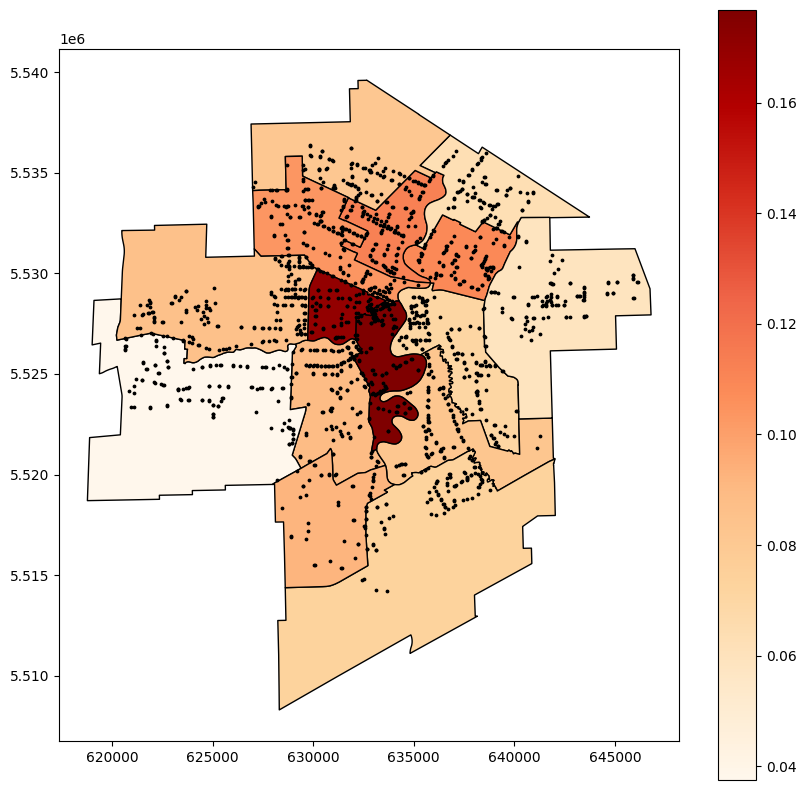

In [333]:
base = ward_map.plot(
    column='transit_user', 
    legend=True,
    figsize=(10,10),
    cmap='OrRd',
    edgecolor='black'

)
# Plot lost stops in yellow
lost_stops_map.plot(ax=base, marker='o', color='black', markersize=3)

In [334]:
#Now the math!

loss_in_ward = lost_stops_map.sjoin(ward_map,how='left',predicate='within')
ward_map['lost_stops'] = loss_in_ward.groupby('index_right')['stop_code'].count().to_list()
ward_map


,name,number,pop2021,pop2016,pop_change,area,pop_den,transit_user,income_avg,income_med,LIM-AT,geometry,lost_stops,added_stops,stop_change,lost_per_km
0,River Heights - Fort Garry,8.0,49990,49030,0.019580,23.184713,2156.162123,0.088728,64200,44400,0.108922,"POLYGON ((629727.907 5526669.054, 629777.183 5...",131,10,-121,5.218956
1,St. Boniface,12.0,46565,46035,0.011513,25.273080,1842.474285,0.070295,52800,43600,0.101256,"POLYGON ((635820.811 5529525.256, 635896.469 5...",153,39,-114,4.510728
2,Elmwood - East Kildonan,14.0,45070,43240,0.042322,14.318824,3147.604859,0.109262,41720,37200,0.153556,"POLYGON ((636079.803 5532301.064, 636417.238 5...",98,21,-77,5.377537
3,Mynarski,2.0,50405,49185,0.024804,14.580302,3457.061452,0.112147,38280,34400,0.187779,"POLYGON ((633107.099 5533136.732, 634355.61 55...",124,28,-96,6.584226
4,St. Vital,11.0,54085,48320,0.119309,24.965575,2166.383110,0.082179,54050,42400,0.125358,"POLYGON ((635333.21 5525946.65, 635441.228 552...",89,39,-50,2.002758
5,Transcona,13.0,50985,44135,0.155206,45.664835,1116.504636,0.059212,49680,44000,0.073068,"POLYGON ((640201.833 5532537.41, 640335.488 55...",110,67,-43,0.941644
6,North Kildonan,15.0,45460,44135,0.030022,20.237797,2246.291926,0.063167,50960,42800,0.099098,"POLYGON ((636807.521 5536872.022, 636820.518 5...",89,16,-73,3.607112
7,Charleswood - Tuxedo - Westwood,7.0,47340,44740,0.058114,71.145917,665.393068,0.037535,69600,49600,0.076468,"POLYGON ((620219.981 5526932.181, 620247.352 5...",134,20,-114,1.602341
8,Fort Rouge - East Fort Garry,9.0,47360,45240,0.046861,14.028922,3375.883051,0.176737,49320,38000,0.194573,"POLYGON ((634257.342 5528646.226, 634266.503 5...",118,17,-101,7.199413
9,Old Kildonan,1.0,53545,46585,0.149404,33.918927,1578.617154,0.081109,42200,36400,0.092072,"POLYGON ((626990.957 5534110.014, 626971.51 55...",88,21,-67,1.975298


### Added stops and transit usage:

<Axes: >

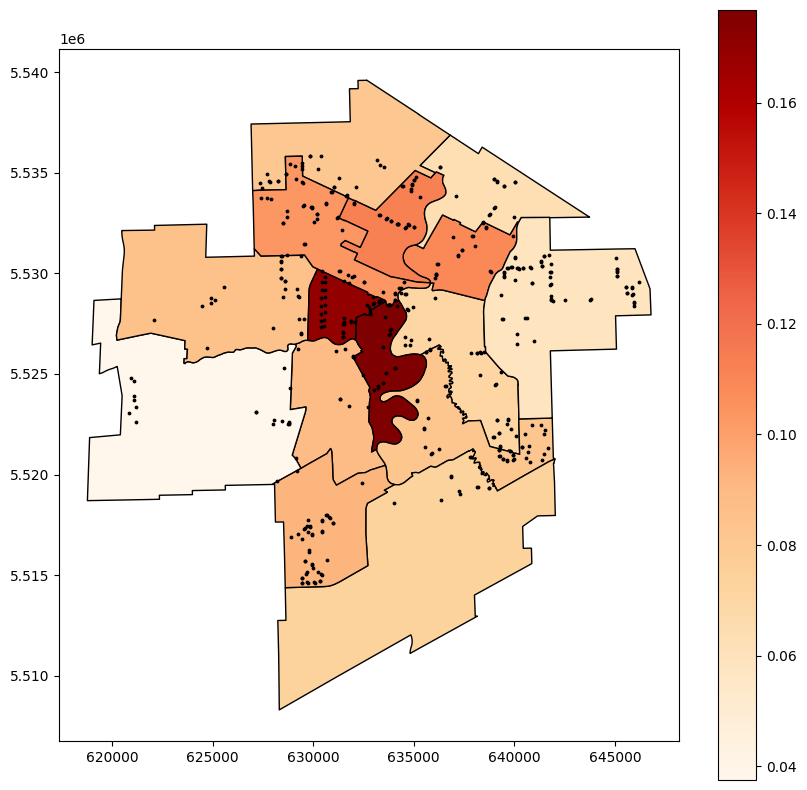

In [335]:
base = ward_map.plot(
    column='transit_user', 
    legend=True,
    figsize=(10,10),
    cmap='OrRd',
    edgecolor='black'

)
# Plot lost stops in yellow
added_stops_map.plot(ax=base, marker='o', color='black', markersize=3)

In [336]:
# And the math!

gain_in_ward = added_stops_map.sjoin(ward_map,how='left',predicate='within')
ward_map['added_stops'] = gain_in_ward.groupby('index_right')['stop_code'].count().to_list()
ward_map


,name,number,pop2021,pop2016,pop_change,area,pop_den,transit_user,income_avg,income_med,LIM-AT,geometry,lost_stops,added_stops,stop_change,lost_per_km
0,River Heights - Fort Garry,8.0,49990,49030,0.019580,23.184713,2156.162123,0.088728,64200,44400,0.108922,"POLYGON ((629727.907 5526669.054, 629777.183 5...",131,10,-121,5.218956
1,St. Boniface,12.0,46565,46035,0.011513,25.273080,1842.474285,0.070295,52800,43600,0.101256,"POLYGON ((635820.811 5529525.256, 635896.469 5...",153,39,-114,4.510728
2,Elmwood - East Kildonan,14.0,45070,43240,0.042322,14.318824,3147.604859,0.109262,41720,37200,0.153556,"POLYGON ((636079.803 5532301.064, 636417.238 5...",98,21,-77,5.377537
3,Mynarski,2.0,50405,49185,0.024804,14.580302,3457.061452,0.112147,38280,34400,0.187779,"POLYGON ((633107.099 5533136.732, 634355.61 55...",124,28,-96,6.584226
4,St. Vital,11.0,54085,48320,0.119309,24.965575,2166.383110,0.082179,54050,42400,0.125358,"POLYGON ((635333.21 5525946.65, 635441.228 552...",89,39,-50,2.002758
5,Transcona,13.0,50985,44135,0.155206,45.664835,1116.504636,0.059212,49680,44000,0.073068,"POLYGON ((640201.833 5532537.41, 640335.488 55...",110,67,-43,0.941644
6,North Kildonan,15.0,45460,44135,0.030022,20.237797,2246.291926,0.063167,50960,42800,0.099098,"POLYGON ((636807.521 5536872.022, 636820.518 5...",89,16,-73,3.607112
7,Charleswood - Tuxedo - Westwood,7.0,47340,44740,0.058114,71.145917,665.393068,0.037535,69600,49600,0.076468,"POLYGON ((620219.981 5526932.181, 620247.352 5...",134,20,-114,1.602341
8,Fort Rouge - East Fort Garry,9.0,47360,45240,0.046861,14.028922,3375.883051,0.176737,49320,38000,0.194573,"POLYGON ((634257.342 5528646.226, 634266.503 5...",118,17,-101,7.199413
9,Old Kildonan,1.0,53545,46585,0.149404,33.918927,1578.617154,0.081109,42200,36400,0.092072,"POLYGON ((626990.957 5534110.014, 626971.51 55...",88,21,-67,1.975298


### Calaculate stop difference by area:

In [337]:
ward_map['stop_change'] = -(ward_map['lost_stops']) + ward_map['added_stops']
ward_map['lost_per_km'] = abs(ward_map['stop_change'])/ward_map['area']
#ward_map.drop(columns='change_per_km', inplace=True)

In [338]:
ward_map.sort_values(by='lost_per_km', ascending=False)

,name,number,pop2021,pop2016,pop_change,area,pop_den,transit_user,income_avg,income_med,LIM-AT,geometry,lost_stops,added_stops,stop_change,lost_per_km
8,Fort Rouge - East Fort Garry,9.0,47360,45240,0.046861,14.028922,3375.883051,0.176737,49320,38000,0.194573,"POLYGON ((634257.342 5528646.226, 634266.503 5...",118,17,-101,7.199413
3,Mynarski,2.0,50405,49185,0.024804,14.580302,3457.061452,0.112147,38280,34400,0.187779,"POLYGON ((633107.099 5533136.732, 634355.61 55...",124,28,-96,6.584226
11,Point Douglas,3.0,49165,45730,0.075115,23.252233,2114.420581,0.103656,39400,34400,0.161802,"POLYGON ((627306.031 5534129.24, 627835.225 55...",181,53,-128,5.504848
2,Elmwood - East Kildonan,14.0,45070,43240,0.042322,14.318824,3147.604859,0.109262,41720,37200,0.153556,"POLYGON ((636079.803 5532301.064, 636417.238 5...",98,21,-77,5.377537
0,River Heights - Fort Garry,8.0,49990,49030,0.019580,23.184713,2156.162123,0.088728,64200,44400,0.108922,"POLYGON ((629727.907 5526669.054, 629777.183 5...",131,10,-121,5.218956
13,Daniel McIntyre,4.0,44145,45460,-0.028927,8.526640,5177.303135,0.169685,39840,33600,0.194586,"POLYGON ((630214.762 5530210.858, 630409.265 5...",79,38,-41,4.808459
1,St. Boniface,12.0,46565,46035,0.011513,25.273080,1842.474285,0.070295,52800,43600,0.101256,"POLYGON ((635820.811 5529525.256, 635896.469 5...",153,39,-114,4.510728
6,North Kildonan,15.0,45460,44135,0.030022,20.237797,2246.291926,0.063167,50960,42800,0.099098,"POLYGON ((636807.521 5536872.022, 636820.518 5...",89,16,-73,3.607112
12,St. James,5.0,48220,47730,0.010266,48.157569,1001.296390,0.085438,49320,42800,0.105143,"POLYGON ((620417.512 5527709.966, 620433.507 5...",186,28,-158,3.280897
4,St. Vital,11.0,54085,48320,0.119309,24.965575,2166.383110,0.082179,54050,42400,0.125358,"POLYGON ((635333.21 5525946.65, 635441.228 552...",89,39,-50,2.002758


# RESULTS

<span style="font-size:1.5em;">

Winnipeg's **Fort Rouge - East Fort Garry, Mynarski and Point Douglas** neighbourhoods lost the highest number of stops per square kilometre, losing 7.2, 6.6 and 5.5 stops per km, respectively. The city wide average is 2.7. Mynarski and Point Douglas are areas of significance in this analysis, having high proportions of low-income residents and residents who primarily commute on transit. The other neighbourhood of significance -- Daniel MacIntyre -- has a stop loss per km of 4.8, ranking sixth. 

Six wards were below the city-wide average. The **Waverly West** neighbourhood saw the fewest lost stops, losing 0.07 stops per sq km. (Net loss of just 2 stops in all.) Of note, this neighbourhood saw the largest population growth of any ward between 2016 and 2021, growing by nearly 30%. **Transcona**, another edge-of-town neighbourhood which lost fewer stops than the city average, had the second largest population growth at 15%. 


## Adding totals data:

For posterity!

In [339]:
# Winnipeg totals can be found in any of the sheets. I'll use whatever was loaded last...

In [340]:
winnipeg = gpd.read_file('map_layers/winnipeg-limit.geojson')
winnipeg = winnipeg.to_crs("epsg:3158")

In [341]:
df['col_5'].iloc[515]

50120

In [342]:

winnipeg['name'] = 'Winnipeg'

winnipeg['number'] = ''

# Column 2: pop2021
winnipeg['pop2021'] = df['col_4'].iloc[53]
   
# Column 3: pop2016
winnipeg['pop2016'] = df['col_4'].iloc[54]

# Column 4: pop_change
winnipeg['pop_change'] = df['col_5'].iloc[53]
 
# Column 5: area
winnipeg['area'] =  df['col_5'].iloc[73]
    
# Column 6: pop_den
winnipeg['pop_den'] = df['col_4'].iloc[53] / df['col_5'].iloc[73]
   

# Column 7: transit_user
winnipeg['transit_user'] = df['col_5'].iloc[476]
  

# Column 8: income_avg
winnipeg['income_avg'] = df['col_5'].iloc[515]
 

# Column 9: income_med
winnipeg['income_med'] = df['col_5'].iloc[516]

# Column 10: LIM-AT
winnipeg['LIM-AT'] = df['col_5'].iloc[524]

In [343]:
winnipeg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   id            1 non-null      object  
 1   geometry      1 non-null      geometry
 2   name          1 non-null      object  
 3   number        1 non-null      object  
 4   pop2021       1 non-null      int64   
 5   pop2016       1 non-null      int64   
 6   pop_change    1 non-null      float64 
 7   area          1 non-null      float64 
 8   pop_den       1 non-null      float64 
 9   transit_user  1 non-null      float64 
 10  income_avg    1 non-null      int64   
 11  income_med    1 non-null      int64   
 12  LIM-AT        1 non-null      float64 
dtypes: float64(5), geometry(1), int64(4), object(3)
memory usage: 236.0+ bytes


In [344]:
winnipeg = winnipeg[['name','number','pop2021','pop2016','pop_change','area','pop_den','transit_user','income_avg','income_med', 'LIM-AT','geometry']]

In [345]:
winnipeg['lost_stops']=len(lost_stops_map)
winnipeg['added_stops']=len(added_stops_map)
winnipeg['stop_change']=-len(lost_stops_map)+len(added_stops_map)
winnipeg['lost_per_km']=abs(winnipeg['stop_change'])/winnipeg['area']

In [346]:
winnipeg

,name,number,pop2021,pop2016,pop_change,area,pop_den,transit_user,income_avg,income_med,LIM-AT,geometry,lost_stops,added_stops,stop_change,lost_per_km
0,Winnipeg,,749607,705244,0.062904,475.2,1577.455808,0.092004,50120,40000,0.129083,"MULTIPOLYGON (((620533.191 5530297.635, 620601...",1720,455,-1265,2.662037


In [347]:
transit_analysis = pd.concat([ward_map, winnipeg], ignore_index=True)

In [348]:
transit_analysis

,name,number,pop2021,pop2016,pop_change,area,pop_den,transit_user,income_avg,income_med,LIM-AT,geometry,lost_stops,added_stops,stop_change,lost_per_km
0,River Heights - Fort Garry,8.0,49990,49030,0.019580,23.184713,2156.162123,0.088728,64200,44400,0.108922,"POLYGON ((629727.907 5526669.054, 629777.183 5...",131,10,-121,5.218956
1,St. Boniface,12.0,46565,46035,0.011513,25.273080,1842.474285,0.070295,52800,43600,0.101256,"POLYGON ((635820.811 5529525.256, 635896.469 5...",153,39,-114,4.510728
2,Elmwood - East Kildonan,14.0,45070,43240,0.042322,14.318824,3147.604859,0.109262,41720,37200,0.153556,"POLYGON ((636079.803 5532301.064, 636417.238 5...",98,21,-77,5.377537
3,Mynarski,2.0,50405,49185,0.024804,14.580302,3457.061452,0.112147,38280,34400,0.187779,"POLYGON ((633107.099 5533136.732, 634355.61 55...",124,28,-96,6.584226
4,St. Vital,11.0,54085,48320,0.119309,24.965575,2166.383110,0.082179,54050,42400,0.125358,"POLYGON ((635333.21 5525946.65, 635441.228 552...",89,39,-50,2.002758
5,Transcona,13.0,50985,44135,0.155206,45.664835,1116.504636,0.059212,49680,44000,0.073068,"POLYGON ((640201.833 5532537.41, 640335.488 55...",110,67,-43,0.941644
6,North Kildonan,15.0,45460,44135,0.030022,20.237797,2246.291926,0.063167,50960,42800,0.099098,"POLYGON ((636807.521 5536872.022, 636820.518 5...",89,16,-73,3.607112
7,Charleswood - Tuxedo - Westwood,7.0,47340,44740,0.058114,71.145917,665.393068,0.037535,69600,49600,0.076468,"POLYGON ((620219.981 5526932.181, 620247.352 5...",134,20,-114,1.602341
8,Fort Rouge - East Fort Garry,9.0,47360,45240,0.046861,14.028922,3375.883051,0.176737,49320,38000,0.194573,"POLYGON ((634257.342 5528646.226, 634266.503 5...",118,17,-101,7.199413
9,Old Kildonan,1.0,53545,46585,0.149404,33.918927,1578.617154,0.081109,42200,36400,0.092072,"POLYGON ((626990.957 5534110.014, 626971.51 55...",88,21,-67,1.975298


In [349]:
# I also just want the total number of stops/stop density to begin with...I think that's important.

In [350]:
old_stops_map = gpd.GeoDataFrame(
    old_stops, 
    geometry=gpd.points_from_xy(old_stops.stop_lon, old_stops.stop_lat), crs="epsg:4326")
old_stops_map = old_stops_map.to_crs("epsg:3158")

In [351]:
old_stops_map

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,geometry
0,10001,10001,Southbound Osborne at Mulvey,49.871261,-97.139518,http://www.winnipegtransit.com/stops/10001,POINT (633687.737 5525975.973)
1,10002,10002,Southbound Osborne at Woodward,49.868819,-97.137553,http://www.winnipegtransit.com/stops/10002,POINT (633835.737 5525707.968)
2,10003,10003,Southbound Osborne at Brandon,49.867880,-97.136795,http://www.winnipegtransit.com/stops/10003,POINT (633892.737 5525604.966)
3,10004,10004,Southbound Osborne at Hethrington,49.866522,-97.135707,http://www.winnipegtransit.com/stops/10004,POINT (633974.737 5525455.963)
4,10005,10005,Southbound Osborne at Morley,49.865164,-97.134604,http://www.winnipegtransit.com/stops/10005,POINT (634057.738 5525306.961)
...,...,...,...,...,...,...,...
5132,62044,62044,Northbound Fort Whyte at Fort Whyte Alive,49.816248,-97.217922,http://www.winnipegtransit.com/stops/62044,POINT (628199.732 5519723.149)
5133,62045,62045,Southbound Brady at Vitran,49.812154,-97.219532,http://www.winnipegtransit.com/stops/62045,POINT (628094.732 5519265.152)
5134,62046,62046,Eastbound Fleetwood at Royal Oak,49.810910,-97.215908,http://www.winnipegtransit.com/stops/62046,POINT (628358.733 5519133.145)
5135,62047,62047,Westbound Fleetwood at Royal Oak,49.811065,-97.216013,http://www.winnipegtransit.com/stops/62047,POINT (628350.733 5519150.145)


<Axes: >

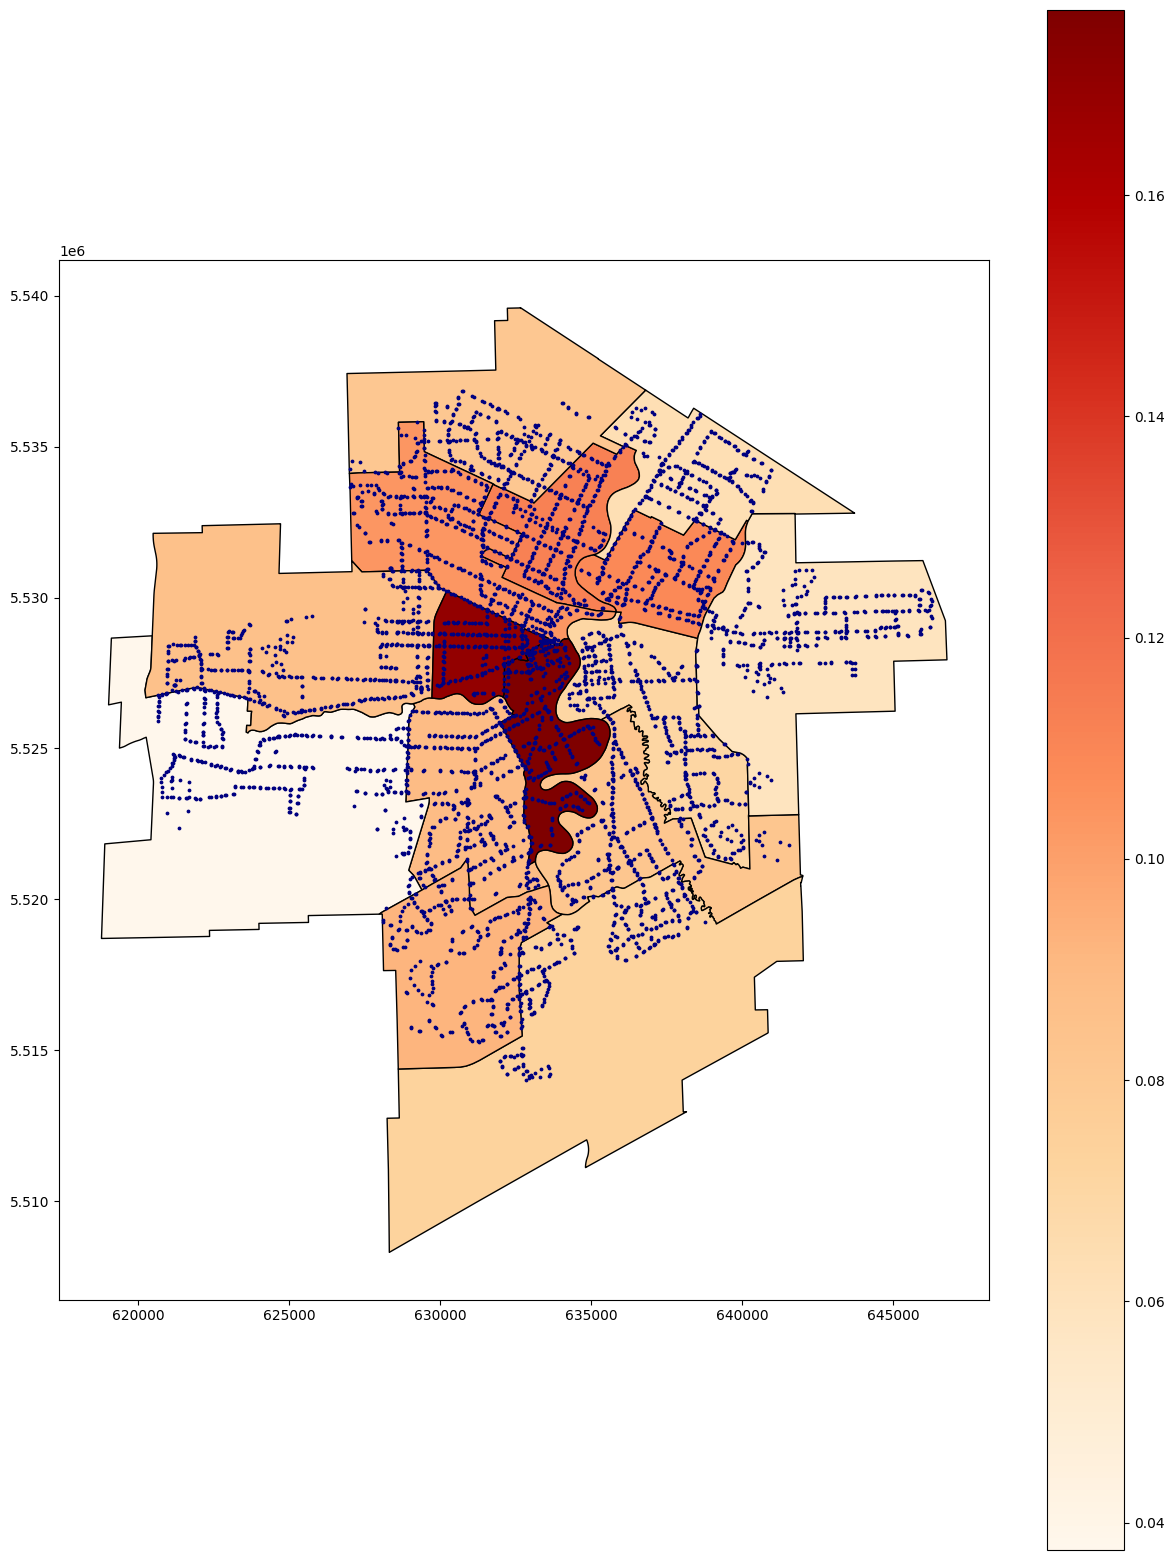

In [352]:
base = ward_map.plot(
    column='transit_user', 
    legend=True,
    figsize=(15,20),
    cmap='OrRd',
    edgecolor='black'

)

old_stops_map.geometry.plot(ax=base, marker='o', color='navy', markersize=3)

In [353]:
stops_in_ward=old_stops_map.sjoin(ward_map,how='left',predicate='within')
stops_in_ward.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,geometry,index_right,name,number,...,area,pop_den,transit_user,income_avg,income_med,LIM-AT,lost_stops,added_stops,stop_change,lost_per_km
0,10001,10001,Southbound Osborne at Mulvey,49.871261,-97.139518,http://www.winnipegtransit.com/stops/10001,POINT (633687.737 5525975.973),8,Fort Rouge - East Fort Garry,9.0,...,14.028922,3375.883051,0.176737,49320,38000,0.194573,118,17,-101,7.199413
1,10002,10002,Southbound Osborne at Woodward,49.868819,-97.137553,http://www.winnipegtransit.com/stops/10002,POINT (633835.737 5525707.968),8,Fort Rouge - East Fort Garry,9.0,...,14.028922,3375.883051,0.176737,49320,38000,0.194573,118,17,-101,7.199413
2,10003,10003,Southbound Osborne at Brandon,49.867880,-97.136795,http://www.winnipegtransit.com/stops/10003,POINT (633892.737 5525604.966),8,Fort Rouge - East Fort Garry,9.0,...,14.028922,3375.883051,0.176737,49320,38000,0.194573,118,17,-101,7.199413
3,10004,10004,Southbound Osborne at Hethrington,49.866522,-97.135707,http://www.winnipegtransit.com/stops/10004,POINT (633974.737 5525455.963),8,Fort Rouge - East Fort Garry,9.0,...,14.028922,3375.883051,0.176737,49320,38000,0.194573,118,17,-101,7.199413
4,10005,10005,Southbound Osborne at Morley,49.865164,-97.134604,http://www.winnipegtransit.com/stops/10005,POINT (634057.738 5525306.961),8,Fort Rouge - East Fort Garry,9.0,...,14.028922,3375.883051,0.176737,49320,38000,0.194573,118,17,-101,7.199413


In [354]:
stops_in_ward = stops_in_ward.groupby('name')['stop_id'].count().to_list()
stops_in_ward

[376, 228, 286, 314, 333, 283, 278, 505, 418, 413, 453, 307, 288, 359, 296]

In [355]:
# add the total winnipeg value:
stops_in_ward.append(5137)

In [356]:
# Add to big dataframe
transit_analysis['stops2024'] = stops_in_ward

In [357]:
# Calculate original stop density

transit_analysis['stop_den_2024'] = transit_analysis['stops2024']/transit_analysis['area']
transit_analysis

,name,number,pop2021,pop2016,pop_change,area,pop_den,transit_user,income_avg,income_med,LIM-AT,geometry,lost_stops,added_stops,stop_change,lost_per_km,stops2024,stop_den_2024
0,River Heights - Fort Garry,8.0,49990,49030,0.019580,23.184713,2156.162123,0.088728,64200,44400,0.108922,"POLYGON ((629727.907 5526669.054, 629777.183 5...",131,10,-121,5.218956,376,16.217583
1,St. Boniface,12.0,46565,46035,0.011513,25.273080,1842.474285,0.070295,52800,43600,0.101256,"POLYGON ((635820.811 5529525.256, 635896.469 5...",153,39,-114,4.510728,228,9.021457
2,Elmwood - East Kildonan,14.0,45070,43240,0.042322,14.318824,3147.604859,0.109262,41720,37200,0.153556,"POLYGON ((636079.803 5532301.064, 636417.238 5...",98,21,-77,5.377537,286,19.973707
3,Mynarski,2.0,50405,49185,0.024804,14.580302,3457.061452,0.112147,38280,34400,0.187779,"POLYGON ((633107.099 5533136.732, 634355.61 55...",124,28,-96,6.584226,314,21.535905
4,St. Vital,11.0,54085,48320,0.119309,24.965575,2166.383110,0.082179,54050,42400,0.125358,"POLYGON ((635333.21 5525946.65, 635441.228 552...",89,39,-50,2.002758,333,13.338367
5,Transcona,13.0,50985,44135,0.155206,45.664835,1116.504636,0.059212,49680,44000,0.073068,"POLYGON ((640201.833 5532537.41, 640335.488 55...",110,67,-43,0.941644,283,6.197329
6,North Kildonan,15.0,45460,44135,0.030022,20.237797,2246.291926,0.063167,50960,42800,0.099098,"POLYGON ((636807.521 5536872.022, 636820.518 5...",89,16,-73,3.607112,278,13.736673
7,Charleswood - Tuxedo - Westwood,7.0,47340,44740,0.058114,71.145917,665.393068,0.037535,69600,49600,0.076468,"POLYGON ((620219.981 5526932.181, 620247.352 5...",134,20,-114,1.602341,505,7.098088
8,Fort Rouge - East Fort Garry,9.0,47360,45240,0.046861,14.028922,3375.883051,0.176737,49320,38000,0.194573,"POLYGON ((634257.342 5528646.226, 634266.503 5...",118,17,-101,7.199413,418,29.795589
9,Old Kildonan,1.0,53545,46585,0.149404,33.918927,1578.617154,0.081109,42200,36400,0.092072,"POLYGON ((626990.957 5534110.014, 626971.51 55...",88,21,-67,1.975298,413,12.176093


In [358]:
# add new stop count/density

transit_analysis['stops2025'] = transit_analysis['stops2024']+transit_analysis['stop_change']

In [359]:
transit_analysis['stop_den_2025'] = transit_analysis['stops2025']/transit_analysis['area']
transit_analysis

,name,number,pop2021,pop2016,pop_change,area,pop_den,transit_user,income_avg,income_med,LIM-AT,geometry,lost_stops,added_stops,stop_change,lost_per_km,stops2024,stop_den_2024,stops2025,stop_den_2025
0,River Heights - Fort Garry,8.0,49990,49030,0.019580,23.184713,2156.162123,0.088728,64200,44400,0.108922,"POLYGON ((629727.907 5526669.054, 629777.183 5...",131,10,-121,5.218956,376,16.217583,255,10.998627
1,St. Boniface,12.0,46565,46035,0.011513,25.273080,1842.474285,0.070295,52800,43600,0.101256,"POLYGON ((635820.811 5529525.256, 635896.469 5...",153,39,-114,4.510728,228,9.021457,114,4.510728
2,Elmwood - East Kildonan,14.0,45070,43240,0.042322,14.318824,3147.604859,0.109262,41720,37200,0.153556,"POLYGON ((636079.803 5532301.064, 636417.238 5...",98,21,-77,5.377537,286,19.973707,209,14.596171
3,Mynarski,2.0,50405,49185,0.024804,14.580302,3457.061452,0.112147,38280,34400,0.187779,"POLYGON ((633107.099 5533136.732, 634355.61 55...",124,28,-96,6.584226,314,21.535905,218,14.951679
4,St. Vital,11.0,54085,48320,0.119309,24.965575,2166.383110,0.082179,54050,42400,0.125358,"POLYGON ((635333.21 5525946.65, 635441.228 552...",89,39,-50,2.002758,333,13.338367,283,11.335609
5,Transcona,13.0,50985,44135,0.155206,45.664835,1116.504636,0.059212,49680,44000,0.073068,"POLYGON ((640201.833 5532537.41, 640335.488 55...",110,67,-43,0.941644,283,6.197329,240,5.255685
6,North Kildonan,15.0,45460,44135,0.030022,20.237797,2246.291926,0.063167,50960,42800,0.099098,"POLYGON ((636807.521 5536872.022, 636820.518 5...",89,16,-73,3.607112,278,13.736673,205,10.129561
7,Charleswood - Tuxedo - Westwood,7.0,47340,44740,0.058114,71.145917,665.393068,0.037535,69600,49600,0.076468,"POLYGON ((620219.981 5526932.181, 620247.352 5...",134,20,-114,1.602341,505,7.098088,391,5.495748
8,Fort Rouge - East Fort Garry,9.0,47360,45240,0.046861,14.028922,3375.883051,0.176737,49320,38000,0.194573,"POLYGON ((634257.342 5528646.226, 634266.503 5...",118,17,-101,7.199413,418,29.795589,317,22.596177
9,Old Kildonan,1.0,53545,46585,0.149404,33.918927,1578.617154,0.081109,42200,36400,0.092072,"POLYGON ((626990.957 5534110.014, 626971.51 55...",88,21,-67,1.975298,413,12.176093,346,10.200794


# Part 5: Rapid Transit Access by ward/population

In QGIS, I created shapes representing the areas within a 10 or 15 minute walk of frequent (rapid) transit service. I then overlaid these shapes on census tracts, and used the overlap feature to calculate the percentage of each tract within walking distance of frequent transit. Using these figures, and the populations in the ward dataset, I will calculate the approximate population with access to rapid transit before and after network changes. 

In [465]:
populations = pd.read_csv('rapid-access/census-populations.csv')
populations.head()

,Unnamed: 0,"Population, 2021"
0,6020001.00,"4,213"
1,6020002.00,"5,540"
2,6020003.00,"5,152"
3,6020004.01,"4,554"
4,6020004.02,"3,549"


In [466]:
populations.columns = ['CTUID', 'population']

In [467]:
populations.dtypes

CTUID         float64
population     object
dtype: object

In [468]:
populations['population'] = populations['population'].str.replace(',','')

In [469]:
populations['population'] = populations['population'].astype(float)

In [500]:
rapid_2025_access = gpd.read_file('rapid-access/census-15min-rapid-access-2025.geojson')

In [501]:
rapid_2025_access['CTUID'] = rapid_2025_access.CTUID.astype(float)

In [502]:
rapid_access = rapid_2025_access.merge(populations, on='CTUID')

In [503]:
rapid_access.head()

,CTUID,DGUID,CTNAME,LANDAREA,PRUID,census-tract-data-clean_pop_density,census-tract-data-clean_transit_users,census-tract-data-clean_pop_change,census-tract-data-clean_poverty_rate,census-tract-data-clean_low_income,10min-rapid-access-2025_area,10min-rapid-access-2025_pc,15min-rapid-access-2025_area,15min-rapid-access-2025_pc,geometry,population
0,6020520.05,2021S05076020520.05,0520.05,26.3221,46,27.5,0.0,8.5,0.0,5.5,0.000000e+00,0.000000,0.000000e+00,0.000000,"MULTIPOLYGON (((-97.23163 49.84506, -97.23292 ...",724.0
1,6020001.00,2021S05076020001.00,0001.00,1.7766,46,2371.4,7.8,-1.5,6.2,7.4,1.422944e+06,69.081104,2.059816e+06,100.000000,"MULTIPOLYGON (((-97.13322 49.87012, -97.13008 ...",4213.0
2,6020002.00,2021S05076020002.00,0002.00,1.8471,46,2999.3,12.7,5.8,8.5,13.9,1.724792e+06,89.588526,1.925238e+06,100.000000,"MULTIPOLYGON (((-97.12725 49.85671, -97.12657 ...",5540.0
3,6020003.00,2021S05076020003.00,0003.00,1.4086,46,3657.5,14.5,-0.2,11.8,13.4,1.376398e+06,97.710581,1.408648e+06,100.000000,"MULTIPOLYGON (((-97.15231 49.85425, -97.1524 4...",5152.0
4,6020005.00,2021S05076020005.00,0005.00,2.3718,46,2323.6,3.8,-4.4,1.7,3.6,1.782709e+06,75.153450,2.112625e+06,89.061704,"MULTIPOLYGON (((-97.17868 49.85133, -97.17904 ...",5511.0


In [504]:
# Now the idea is to just multiply the population by the % access

rapid_access['2025pop_15min'] = rapid_access['population']*(rapid_access['15min-rapid-access-2025_pc']/100)

In [505]:
rapid_access['2025pop_10min'] = rapid_access['population']*(rapid_access['10min-rapid-access-2025_pc']/100)

In [506]:
rapid_access

,CTUID,DGUID,CTNAME,LANDAREA,PRUID,census-tract-data-clean_pop_density,census-tract-data-clean_transit_users,census-tract-data-clean_pop_change,census-tract-data-clean_poverty_rate,census-tract-data-clean_low_income,10min-rapid-access-2025_area,10min-rapid-access-2025_pc,15min-rapid-access-2025_area,15min-rapid-access-2025_pc,geometry,population,2025pop_15min,2025pop_10min
0,6020520.05,2021S05076020520.05,0520.05,26.3221,46,27.5,0.0,8.5,0.0,5.5,0.000000e+00,0.000000,0.000000e+00,0.000000,"MULTIPOLYGON (((-97.23163 49.84506, -97.23292 ...",724.0,0.000000,0.000000
1,6020001.00,2021S05076020001.00,0001.00,1.7766,46,2371.4,7.8,-1.5,6.2,7.4,1.422944e+06,69.081104,2.059816e+06,100.000000,"MULTIPOLYGON (((-97.13322 49.87012, -97.13008 ...",4213.0,4213.000000,2910.386912
2,6020002.00,2021S05076020002.00,0002.00,1.8471,46,2999.3,12.7,5.8,8.5,13.9,1.724792e+06,89.588526,1.925238e+06,100.000000,"MULTIPOLYGON (((-97.12725 49.85671, -97.12657 ...",5540.0,5540.000000,4963.204332
3,6020003.00,2021S05076020003.00,0003.00,1.4086,46,3657.5,14.5,-0.2,11.8,13.4,1.376398e+06,97.710581,1.408648e+06,100.000000,"MULTIPOLYGON (((-97.15231 49.85425, -97.1524 4...",5152.0,5152.000000,5034.049129
4,6020005.00,2021S05076020005.00,0005.00,2.3718,46,2323.6,3.8,-4.4,1.7,3.6,1.782709e+06,75.153450,2.112625e+06,89.061704,"MULTIPOLYGON (((-97.17868 49.85133, -97.17904 ...",5511.0,4908.190526,4141.706618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,6020100.10,2021S05076020100.10,0100.10,1.5457,46,3719.4,3.8,-2.7,3.0,5.1,1.542575e+06,98.854034,1.560457e+06,100.000000,"MULTIPOLYGON (((-97.08139 49.82168, -97.08123 ...",5749.0,5749.000000,5683.118414
166,6020500.10,2021S05076020500.10,0500.10,1.8869,46,3290.1,7.1,-0.9,21.5,19.7,9.724119e+05,51.141800,1.552034e+06,81.625696,"MULTIPOLYGON (((-97.15803 49.80384, -97.15823 ...",6208.0,5067.323223,3174.882945
167,6020500.11,2021S05076020500.11,0500.11,3.7967,46,1815.5,3.8,8.2,12.7,15.4,0.000000e+00,0.000000,1.561159e+03,0.040469,"MULTIPOLYGON (((-97.17384 49.80379, -97.17381 ...",6893.0,2.789535,0.000000
168,6020500.12,2021S05076020500.12,0500.12,4.0166,46,1826.4,5.8,52.1,13.1,15.6,0.000000e+00,0.000000,4.273047e+03,0.106260,"MULTIPOLYGON (((-97.18105 49.76895, -97.18249 ...",7336.0,7.795212,0.000000


In [507]:
# Let's pull in the 24 numbers I think

rapid_2024_access = gpd.read_file('rapid-access/census-15min-rapid-access-2024.geojson')

In [508]:
rapid_2024_access = rapid_2024_access[['CTUID', '10min-rapid-access-2024_pc', '15min-rapid-access-2024_pc']].copy()
rapid_2024_access['CTUID'] = rapid_2024_access['CTUID'].astype(float)

In [509]:
rapid_access = rapid_access.merge(rapid_2024_access, on='CTUID')

In [510]:
# Same math!
rapid_access['2024pop_15min'] = rapid_access['population']*(rapid_access['15min-rapid-access-2024_pc']/100)
rapid_access['2024pop_10min'] = rapid_access['population']*(rapid_access['10min-rapid-access-2024_pc']/100)

In [511]:
# Quick calculations for city wide

access_change_15 = (rapid_access['2025pop_15min'].sum()-rapid_access['2024pop_15min'].sum())/rapid_access['2024pop_15min'].sum()
access_change_10 = (rapid_access['2025pop_10min'].sum()-rapid_access['2024pop_10min'].sum())/rapid_access['2024pop_10min'].sum()

In [512]:
print(f' The population within a 10 minute walk of frequent transit service has increased by {access_change_10 * 100: .1f} percent.')
print(f' The population within a 15 minute walk of frequent transit service has increased by {access_change_15 * 100: .1f} percent.')

 The population within a 10 minute walk of frequent transit service has increased by  82.5 percent.
 The population within a 15 minute walk of frequent transit service has increased by  69.8 percent.


In [515]:
# Now let's get the % difference for each CTUID:
rapid_access['change10min'] = (rapid_access['2025pop_10min']-rapid_access['2024pop_10min'])/rapid_access['2024pop_10min']
rapid_access['change15min'] = (rapid_access['2025pop_15min']-rapid_access['2024pop_15min'])/rapid_access['2024pop_15min']

In [516]:
rapid_access

,CTUID,DGUID,CTNAME,LANDAREA,PRUID,census-tract-data-clean_pop_density,census-tract-data-clean_transit_users,census-tract-data-clean_pop_change,census-tract-data-clean_poverty_rate,census-tract-data-clean_low_income,...,geometry,population,2025pop_15min,2025pop_10min,10min-rapid-access-2024_pc,15min-rapid-access-2024_pc,2024pop_15min,2024pop_10min,change10min,change15min
0,6020520.05,2021S05076020520.05,0520.05,26.3221,46,27.5,0.0,8.5,0.0,5.5,...,"MULTIPOLYGON (((-97.23163 49.84506, -97.23292 ...",724.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
1,6020001.00,2021S05076020001.00,0001.00,1.7766,46,2371.4,7.8,-1.5,6.2,7.4,...,"MULTIPOLYGON (((-97.13322 49.87012, -97.13008 ...",4213.0,4213.000000,2910.386912,3.618454,13.131890,553.246528,152.445466,18.091331,6.615050
2,6020002.00,2021S05076020002.00,0002.00,1.8471,46,2999.3,12.7,5.8,8.5,13.9,...,"MULTIPOLYGON (((-97.12725 49.85671, -97.12657 ...",5540.0,5540.000000,4963.204332,54.513929,82.427493,4566.483093,3020.071676,0.643406,0.213187
3,6020003.00,2021S05076020003.00,0003.00,1.4086,46,3657.5,14.5,-0.2,11.8,13.4,...,"MULTIPOLYGON (((-97.15231 49.85425, -97.1524 4...",5152.0,5152.000000,5034.049129,99.042249,100.000000,5152.000000,5102.656677,-0.013445,0.000000
4,6020005.00,2021S05076020005.00,0005.00,2.3718,46,2323.6,3.8,-4.4,1.7,3.6,...,"MULTIPOLYGON (((-97.17868 49.85133, -97.17904 ...",5511.0,4908.190526,4141.706618,42.898669,65.180392,3592.091406,2364.145673,0.751883,0.366388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,6020100.10,2021S05076020100.10,0100.10,1.5457,46,3719.4,3.8,-2.7,3.0,5.1,...,"MULTIPOLYGON (((-97.08139 49.82168, -97.08123 ...",5749.0,5749.000000,5683.118414,0.000000,0.000000,0.000000,0.000000,inf,inf
166,6020500.10,2021S05076020500.10,0500.10,1.8869,46,3290.1,7.1,-0.9,21.5,19.7,...,"MULTIPOLYGON (((-97.15803 49.80384, -97.15823 ...",6208.0,5067.323223,3174.882945,51.248710,81.746872,5074.845800,3181.519926,-0.002086,-0.001482
167,6020500.11,2021S05076020500.11,0500.11,3.7967,46,1815.5,3.8,8.2,12.7,15.4,...,"MULTIPOLYGON (((-97.17384 49.80379, -97.17381 ...",6893.0,2.789535,0.000000,0.000000,0.040469,2.789535,0.000000,NaN,0.000000
168,6020500.12,2021S05076020500.12,0500.12,4.0166,46,1826.4,5.8,52.1,13.1,15.6,...,"MULTIPOLYGON (((-97.18105 49.76895, -97.18249 ...",7336.0,7.795212,0.000000,0.000000,0.106260,7.795212,0.000000,NaN,0.000000


# Export files:

In [199]:
transit_analysis.to_file('data_output/ward_transit_analysis.geojson')
transit_analysis.to_csv('data_output/ward_transit_analysis.csv')

In [331]:
census.to_file('data_output/census_analysis.geojson')
census.to_csv('data_output/census_analysis.csv')

In [330]:
quant_analysis.to_csv('data_output/mbm_quant_transit_analysis.csv')
transit_user_analysis.to_csv('data_output/transit_user_analysis.csv')

In [204]:
lost_stops_map.to_file('data_output/lost_stops_map.geojson')

In [205]:
added_stops_map.to_file('data_output/added_stops_map.geojson')

In [517]:
rapid_access.to_csv('data_output/rapid_access_data.csv')

# _END OF NOTEBOOK_